In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from math import log
import os
import json
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import folium
from math import exp

# LECTURA DEL DATA SET E INFORMACION

In [649]:
df = pd.read_csv('listings.csv')
df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6369,https://www.airbnb.com/rooms/6369,20201217180603,2020-12-19,"Rooftop terrace room , ensuite bathroom",Excellent connection with the AIRPORT and EXHI...,NaN,https://a0.muscache.com/pictures/683224/4cc318...,13660,https://www.airbnb.com/users/show/13660,...,10.0,10.0,10.0,NaN,f,1,0,1,0,0.59
1,21853,https://www.airbnb.com/rooms/21853,20201217180603,2020-12-19,Bright and airy room,We have a quiet and sunny room with a good vie...,We live in a leafy neighbourhood with plenty o...,https://a0.muscache.com/pictures/68483181/87bc...,83531,https://www.airbnb.com/users/show/83531,...,10.0,8.0,9.0,NaN,f,2,0,2,0,0.44
2,23001,https://www.airbnb.com/rooms/23001,20201217180603,2020-12-18,Apartmento Arganzuela- Madrid Rio,"Apartamento de tres dormitorios dobles, gran s...","Barrio Arganzuela, junto a Madrid Rio, zonas c...",https://a0.muscache.com/pictures/58e6a770-509c...,82175,https://www.airbnb.com/users/show/82175,...,NaN,NaN,NaN,NaN,f,6,5,1,0,NaN
3,24805,https://www.airbnb.com/rooms/24805,20201217180603,2020-12-18,Gran Via Studio Madrid,"Studio located 50 meters from Gran Via, next t...","The area is next to the Gran Via, so people li...",https://a0.muscache.com/pictures/miso/Hosting-...,101471,https://www.airbnb.com/users/show/101471,...,10.0,10.0,10.0,NaN,f,1,1,0,0,0.14
4,24836,https://www.airbnb.com/rooms/24836,20201217180603,2020-12-19,"Select the Madrid more ""cool"".","<b>The space</b><br />Select the Madrid more ""...",NaN,https://a0.muscache.com/pictures/573273/8f594d...,101653,https://www.airbnb.com/users/show/101653,...,10.0,10.0,10.0,VT-296,f,1,1,0,0,0.58


In [650]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20352 entries, 0 to 20351
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            20352 non-null  int64  
 1   listing_url                                   20352 non-null  object 
 2   scrape_id                                     20352 non-null  int64  
 3   last_scraped                                  20352 non-null  object 
 4   name                                          20349 non-null  object 
 5   description                                   19245 non-null  object 
 6   neighborhood_overview                         12239 non-null  object 
 7   picture_url                                   20351 non-null  object 
 8   host_id                                       20352 non-null  int64  
 9   host_url                                      20352 non-null 

# LIMPIEZA DEL DATASET

In [658]:
df.isnull().sum().sort_values(ascending=False).head(42)

bathrooms                      717
calendar_updated               717
license                        611
host_about                     346
review_scores_rating           261
review_scores_value            261
review_scores_location         261
review_scores_communication    261
review_scores_checkin          261
review_scores_cleanliness      261
review_scores_accuracy         261
first_review                   247
reviews_per_month              247
last_review                    247
host_response_time             220
host_response_rate             220
neighborhood_overview          204
neighbourhood                  204
host_acceptance_rate           170
host_neighbourhood             158
bedrooms                        31
description                     29
beds                             9
bathrooms_text                   2
host_location                    1
host_picture_url                 0
availability_30                  0
availability_60                  0
availability_90     

In [659]:
indices_cat = []
indices_num = []
for i in df.columns:
    if df[i].dtype == 'object':
        indices_cat.append(i)
    else:
        indices_num.append(i)
df_cat = df[indices_cat]
df_num = df[indices_num]

In [660]:
#Valores nulos numericos tratamiento: Primero veremos si alguno tiene mas del 80% de nulos, si es asi, nos cargaremos esa variable

df_num.isnull().sum().sort_values(ascending=False).head(18)*100/df_num.shape[0]

#Observamos que calendar_updated y bathrooms tienen el 100% de nulos, fuera
#Observamos que entre las reviews tienen entre 28-30% de nulos.
#El resto de variables que tienen nulos son pocos nulos.

calendar_updated                                100.000000
bathrooms                                       100.000000
review_scores_value                              36.401674
review_scores_location                           36.401674
review_scores_communication                      36.401674
review_scores_checkin                            36.401674
review_scores_cleanliness                        36.401674
review_scores_accuracy                           36.401674
review_scores_rating                             36.401674
reviews_per_month                                34.449093
bedrooms                                          4.323570
beds                                              1.255230
calculated_host_listings_count_shared_rooms       0.000000
calculated_host_listings_count_private_rooms      0.000000
calculated_host_listings_count_entire_homes       0.000000
calculated_host_listings_count                    0.000000
scrape_id                                         0.0000

In [661]:
#Nos cargamos bathroom y calendar_updated
del df_num['bathrooms']
del df_num['calendar_updated']
df_num

,index,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11,47957,20201217180603,218515,1.0,1.0,40.42761,-3.67604,3,2.0,...,10.0,10.0,10.0,10.0,10.0,2,2,0,0,0.45
1,21,82481,20201217180603,448981,1.0,1.0,40.42315,-3.68279,2,1.0,...,10.0,10.0,10.0,10.0,9.0,1,1,0,0,0.92
2,57,200828,20201217180603,75944,5.0,5.0,40.43186,-3.68515,8,2.0,...,NaN,NaN,NaN,NaN,NaN,1,1,0,0,NaN
3,82,282715,20201217180603,1473247,1.0,1.0,40.42586,-3.68468,4,2.0,...,10.0,10.0,10.0,10.0,9.0,1,1,0,0,1.06
4,123,406341,20201217180603,2024487,1.0,1.0,40.42957,-3.67810,1,1.0,...,10.0,10.0,10.0,10.0,10.0,1,0,1,0,1.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,20181,46811766,20201217180603,48033079,31.0,31.0,40.43154,-3.67449,6,1.0,...,NaN,NaN,NaN,NaN,NaN,29,29,0,0,NaN
713,20186,46817041,20201217180603,378268743,0.0,0.0,40.42281,-3.67634,7,2.0,...,NaN,NaN,NaN,NaN,NaN,1,1,0,0,NaN
714,20251,46957921,20201217180603,107141654,69.0,69.0,40.42269,-3.68324,2,1.0,...,NaN,NaN,NaN,NaN,NaN,72,72,0,0,NaN
715,20273,47002661,20201217180603,147205419,0.0,0.0,40.43180,-3.67438,2,1.0,...,NaN,NaN,NaN,NaN,NaN,1,0,1,0,NaN


In [662]:
del df_num['index']

In [663]:
#Vamos a tratar los nulos restantes numericos
nulos_mode = (df_num.isnull().sum().sort_values(ascending=False).head(10)*100/df_num.shape[0]).index
nulos_mean = (df_num.isnull().sum().sort_values(ascending=False).tail(27)*100/df_num.shape[0]).index

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df_num1 = imputer.fit_transform(df[nulos_mean])
df_num1 = pd.DataFrame(df_num1, columns = nulos_mean)

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_num2 = imputer.fit_transform(df[nulos_mode])
df_num2 = pd.DataFrame(df_num2, columns = nulos_mode)

df_num = pd.concat([df_num1,df_num2], axis = 1)
df_num.isnull().sum()

availability_90                                 0
calculated_host_listings_count                  0
calculated_host_listings_count_entire_homes     0
calculated_host_listings_count_private_rooms    0
calculated_host_listings_count_shared_rooms     0
number_of_reviews_l30d                          0
number_of_reviews_ltm                           0
number_of_reviews                               0
availability_365                                0
id                                              0
availability_60                                 0
minimum_nights                                  0
host_id                                         0
host_listings_count                             0
host_total_listings_count                       0
latitude                                        0
longitude                                       0
accommodates                                    0
maximum_nights                                  0
scrape_id                                       0


In [664]:
#Vamos a tratar a los categoricos los valores perdidos
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Missing')
df_cat2 = imputer.fit_transform(df_cat)
df_cat = pd.DataFrame(df_cat2, columns = df_cat.columns)
df_cat

,listing_url,last_scraped,name,description,neighborhood_overview,picture_url,host_url,host_name,host_since,host_location,...,room_type,bathrooms_text,amenities,price,has_availability,calendar_last_scraped,first_review,last_review,license,instant_bookable
0,https://www.airbnb.com/rooms/47957,2020-12-18,"Amazing Apartment, Salamanca Distri",<b>The space</b><br />Totally remodeled modern...,Missing,https://a0.muscache.com/pictures/463140/d47b22...,https://www.airbnb.com/users/show/218515,Sergio,2010-08-31,United States,...,Entire home/apt,2 baths,"[""Coffee maker"", ""Children\u2019s books and to...",$82.00,t,2020-12-18,2010-12-16,2018-07-10,Missing,f
1,https://www.airbnb.com/rooms/82481,2020-12-18,"Retiro Park, Stay at cosy studio","Studio inside house, but independent from it. ...",Missing,https://a0.muscache.com/pictures/580935/ddc661...,https://www.airbnb.com/users/show/448981,Mercedes,2011-03-18,"Madrid, Madrid, Spain",...,Entire home/apt,1 bath,"[""Hair dryer"", ""Shampoo"", ""Kitchen"", ""Essentia...",$63.00,t,2020-12-18,2011-05-08,2017-11-29,Missing,f
2,https://www.airbnb.com/rooms/200828,2020-12-18,"FRENTE MAR, ZONA CALAS. PISCINA.",SITUADO EN UNA LADERA DE LA MONTAÑA QUE HAY FR...,es la unica sierra virgen no edificada del med...,https://a0.muscache.com/pictures/28820474-9bcd...,https://www.airbnb.com/users/show/75944,Maite,2010-01-31,"Peniscola, Valencian Community, Spain",...,Entire home/apt,1 bath,[],$214.00,t,2020-12-18,Missing,Missing,33866,f
3,https://www.airbnb.com/rooms/282715,2020-12-18,"Cozy and Luxury Penthouse, GL*****Madrid",En una de las calles mas prestigiosas del mara...,"Se puede caminar hasta el impresionante ""Parqu...",https://a0.muscache.com/pictures/23416514/9c2a...,https://www.airbnb.com/users/show/1473247,Marta,2011-12-05,"Madrid, Madrid, Spain",...,Entire home/apt,2 baths,"[""Oven"", ""Coffee maker"", ""EV charger"", ""First ...",$120.00,t,2020-12-18,2012-05-22,2020-03-03,Missing,f
4,https://www.airbnb.com/rooms/406341,2020-12-18,"Quiet downtown Madrid, nearby all","Exterior single room, with all you need to stu...",The property has lifelong neighbors and discre...,https://a0.muscache.com/pictures/60519829/2a3a...,https://www.airbnb.com/users/show/2024487,Fernando,2012-03-28,"Madrid, Madrid, Spain",...,Private room,1.5 baths,"[""Oven"", ""Coffee maker"", ""First aid kit"", ""Lon...",$25.00,t,2020-12-18,2012-04-20,2020-07-25,Missing,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,https://www.airbnb.com/rooms/46811766,2020-12-19,Nuevo piso 03 barrio Salamanca,Piso a estrenar desde el 4 diciembre de 2020 q...,En plena calle de juan bravo en el mejor barri...,https://a0.muscache.com/pictures/45577d99-7147...,https://www.airbnb.com/users/show/48033079,Isaac,2015-11-03,"Madrid, Community of Madrid, Spain",...,Entire home/apt,1.5 baths,"[""Carbon monoxide alarm"", ""Dedicated workspace...",$80.00,t,2020-12-19,Missing,Missing,Missing,t
713,https://www.airbnb.com/rooms/46817041,2020-12-19,"NEW! Style, Design, Class & Elegance @ Goya/Re...","You will love this LUXURIOUS, STYLISH, recentl...","""BARRIO DE SALAMANCA/ RETIRO"" is Madrid’s most...",https://a0.muscache.com/pictures/1875ac3d-6ccf...,https://www.airbnb.com/users/show/378268743,Andrea,2020-12-04,"London, England, United Kingdom",...,Entire home/apt,1 bath,"[""Changing table"", ""Coffee maker"", ""High chair...",$37.00,t,2020-12-19,Missing,Missing,Missing,f
714,https://www.airbnb.com/rooms/46957921,2020-12-18,"x. ALCALÁ w/ VELÁZQUEZ, perfect COUPLES or WORK",Perfect apartment for a COUPLE GETAWAY in the ...,"In the center of Madrid, the apartment is loca...",https://a0.muscache.com/pictures/c7bf72a1-ad62...,https://www.airbnb.com/users/show/107141654,Leeways,2016-12-13,"Madrid, Comunidad de Madrid, Spain",...,Entire home/apt,1 bath,"[""Coffee maker"", ""Cooking basics"", ""Essentials...",$116.00,t,2020-12-18,Missing,Missing,Missing,t
715,https://www.airbnb.com/rooms/47002661,2020-12-19,Bright Spacious 

# ANALIZAR LA VARIABLE TARGET: PRICE

In [665]:
precios = []
for i in df['price'].values:
    if ',' in i:
        precios.append(float(i.replace(',','.')[:-3].split('$')[1]))
    else:
        precios.append(float(i.split('$')[1]))
df['price'] = precios

C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


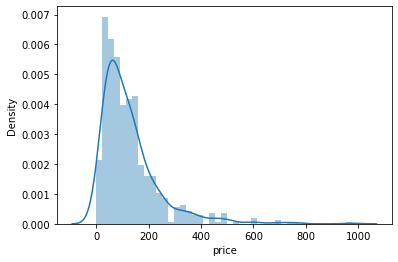

In [666]:
sns.distplot(df['price'])
plt.show()
#Distribucion normal descentrada, aplicar logaritmo

In [667]:
#Vamos a borrar los que tengan 'price = 0'
df_num.drop(axis = 0,index = df[df['price'] == 0].index, inplace=True)
df_cat.drop(axis = 0,index = df[df['price'] == 0].index, inplace=True)

In [668]:
#Cambiamos 'price' de df_cat a df_num
df_num['price'] = df['price']
del df_cat['price']

C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


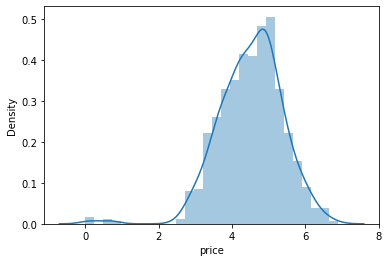

In [669]:
df_num['price'] = [log(i) for i in df_num['price']]
sns.distplot(df_num['price'])
plt.show()

# ANALISIS CORRELACIONES

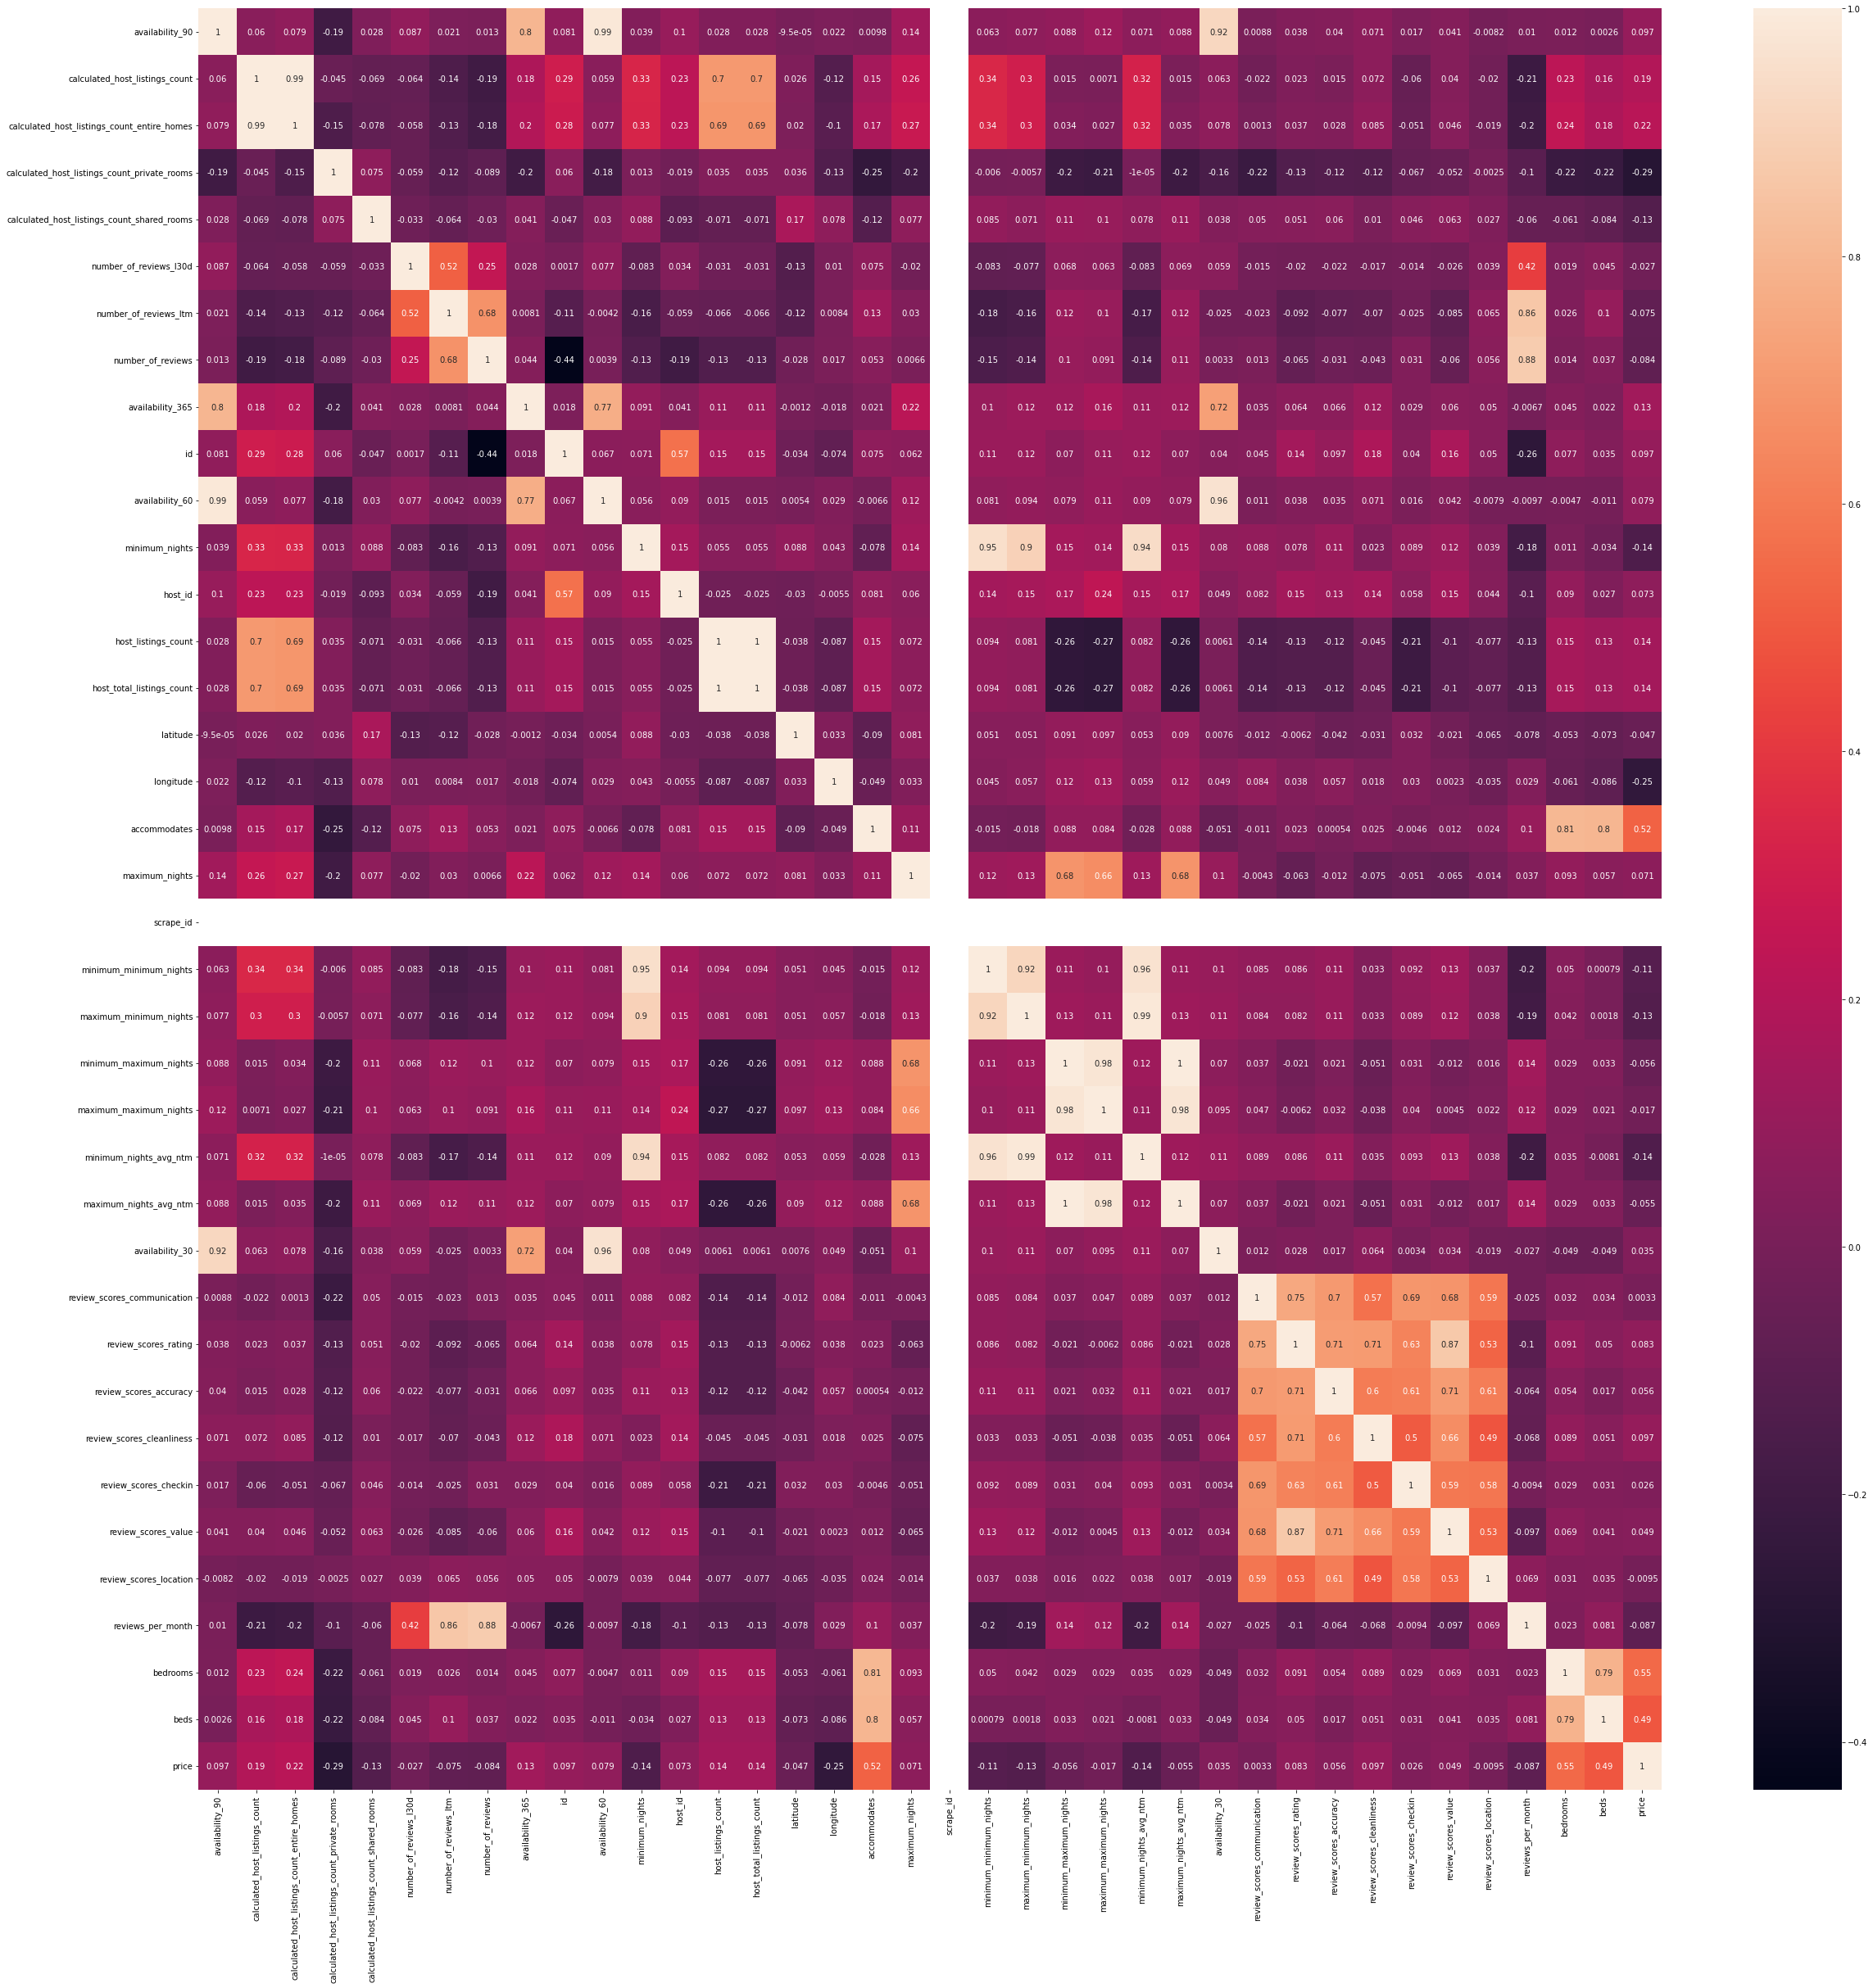

In [670]:
ax, fig = plt.subplots(figsize=(40,40))
sns.heatmap(df_num.corr(),annot=True)
plt.show()
#En el mapa de correlaciones observamos un valor anormal, scrape_id

In [671]:
df_num['scrape_id'].value_counts()
#Solo tiene un valor scrape_id, por lo tanto, no tiene nada que ver en el modelo, asi que nos lo cargamos
del df_num['scrape_id']

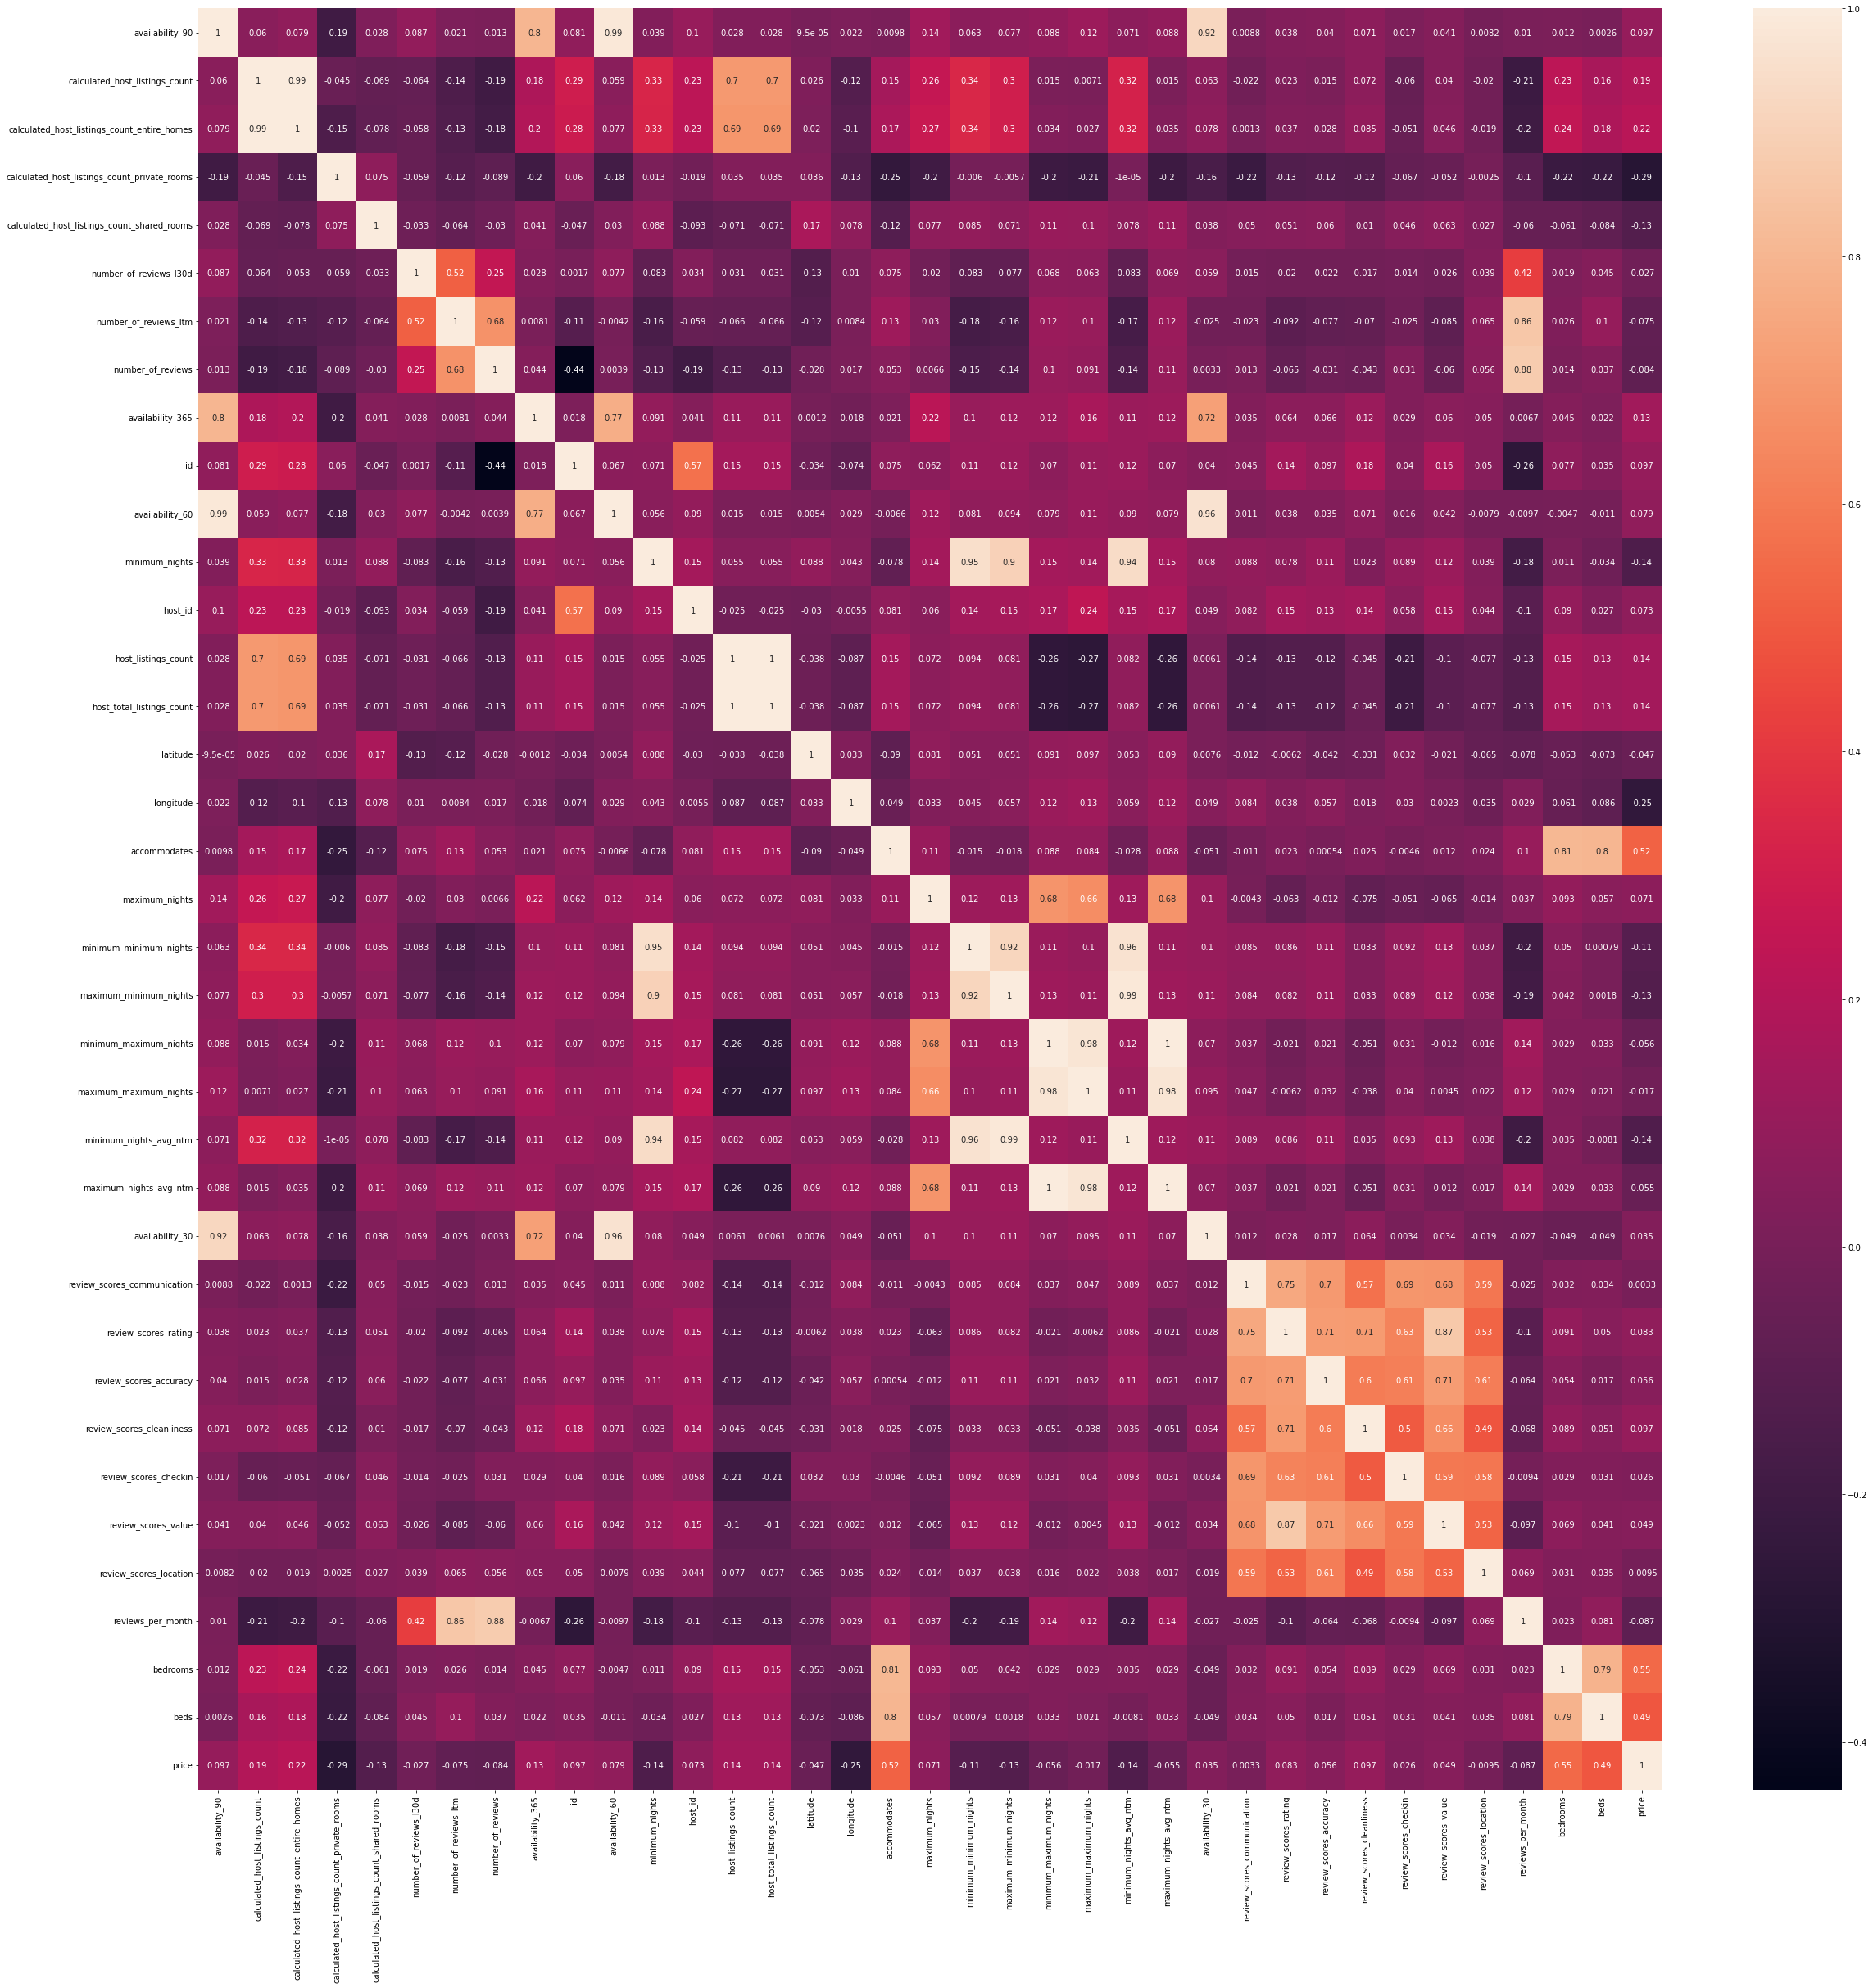

In [672]:
ax, fig = plt.subplots(figsize=(40,40))
sns.heatmap(df_num.corr(),annot=True)
plt.show()
#Vemos que hay muchisimas correlaciones entre variables, vamos a estudiarlas

In [673]:
def correlaciones_altas(df_num):
    repetidos = []
    holas = []
    for i in list(df_num.columns.values):
        for j in list(df_num.columns.values):
            
            if df[[i,j]].corr().iloc[0,1] > 0.7 and i != j and i != 'price' and j != 'price' and j not in repetidos:
                if df_num[[i,'price']].corr().iloc[0,1] >= df_num[[j,'price']].corr().iloc[0,1]:
                    holas.append(j)
                else:
                    holas.append(i)
                repetidos.append(i)
                print(i, j, 'Correlacion: ', df_num[[i,j]].corr().iloc[0,1])
                print(i, 'Price\tCorrelacion: ',df_num[[i,'price']].corr().iloc[0,1])
                print(j, 'Price\tCorrelacion: ',df_num[[j,'price']].corr().iloc[0,1])
    return holas
#Variables que machacamos: review_scores_accuracy,review_scores_checkin,review_scores_rating,review_scores_value,reviews_per_month
#maximum_nights,availability_90,availability_365, maximum_minimum_nights, minimum_minimum_nights,maximum_maximum_nights,maximum_nights_avg_ntm
#minimum_nights_avg_ntm,calculated_host_listings_count,beds

In [674]:
deletear = list(set(correlaciones_altas(df_num)))
for i in deletear:
    del df_num[i]
df_num

availability_90 availability_365 Correlacion:  0.7992916080369411
availability_90 Price	Correlacion:  0.09694534889429694
availability_365 Price	Correlacion:  0.13478086504359701
availability_90 availability_60 Correlacion:  0.9871602897873281
availability_90 Price	Correlacion:  0.09694534889429694
availability_60 Price	Correlacion:  0.07915631448676674
availability_90 availability_30 Correlacion:  0.9227691296012251
availability_90 Price	Correlacion:  0.09694534889429694
availability_30 Price	Correlacion:  0.034790538935673104
calculated_host_listings_count calculated_host_listings_count_entire_homes Correlacion:  0.9947837499517089
calculated_host_listings_count Price	Correlacion:  0.1908866603318222
calculated_host_listings_count_entire_homes Price	Correlacion:  0.21759920122353768
number_of_reviews_ltm reviews_per_month Correlacion:  0.8601211503819435
number_of_reviews_ltm Price	Correlacion:  -0.07507548464739112
reviews_per_month Price	Correlacion:  -0.08727973415027895
number_of

,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,number_of_reviews_l30d,number_of_reviews_ltm,number_of_reviews,availability_365,id,host_id,host_listings_count,...,maximum_nights,minimum_minimum_nights,maximum_maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_location,bedrooms,price
0,2.0,0.0,0.0,0.0,0.0,55.0,362.0,47957.0,218515.0,1.0,...,999.0,10.0,999.0,97.0,10.0,10.0,10.0,10.0,2.0,4.406719
1,1.0,0.0,0.0,0.0,0.0,108.0,0.0,82481.0,448981.0,1.0,...,365.0,3.0,365.0,96.0,9.0,10.0,10.0,10.0,1.0,4.143135
2,1.0,0.0,0.0,0.0,0.0,0.0,365.0,200828.0,75944.0,5.0,...,1125.0,7.0,1125.0,100.0,10.0,10.0,10.0,10.0,2.0,5.365976
3,1.0,0.0,0.0,0.0,8.0,111.0,364.0,282715.0,1473247.0,1.0,...,365.0,2.0,365.0,97.0,10.0,10.0,10.0,10.0,2.0,4.787492
4,0.0,1.0,0.0,0.0,7.0,124.0,195.0,406341.0,2024487.0,1.0,...,180.0,3.0,180.0,99.0,10.0,10.0,10.0,10.0,1.0,3.218876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,29.0,0.0,0.0,0.0,0.0,0.0,180.0,46811766.0,48033079.0,31.0,...,365.0,1.0,365.0,100.0,10.0,10.0,10.0,10.0,1.0,4.382027
713,1.0,0.0,0.0,0.0,0.0,0.0,79.0,46817041.0,378268743.0,0.0,...,1125.0,2.0,1125.0,100.0,10.0,10.0,10.0,10.0,2.0,3.610918
714,72.0,0.0,0.0,0.0,0.0,0.0,356.0,46957921.0,107141654.0,69.0,...,30.0,3.0,30.0,100.0,10.0,10.0,10.0,10.0,1.0,4.753590
715,0.0,1.0,0.0,0.0,0.0,0.0,0.0,47002661.0,147205419.0,0.0,...,19.0,1.0,1125.0,100.0,10.0,10.0,10.0,10.0,1.0,2.890372


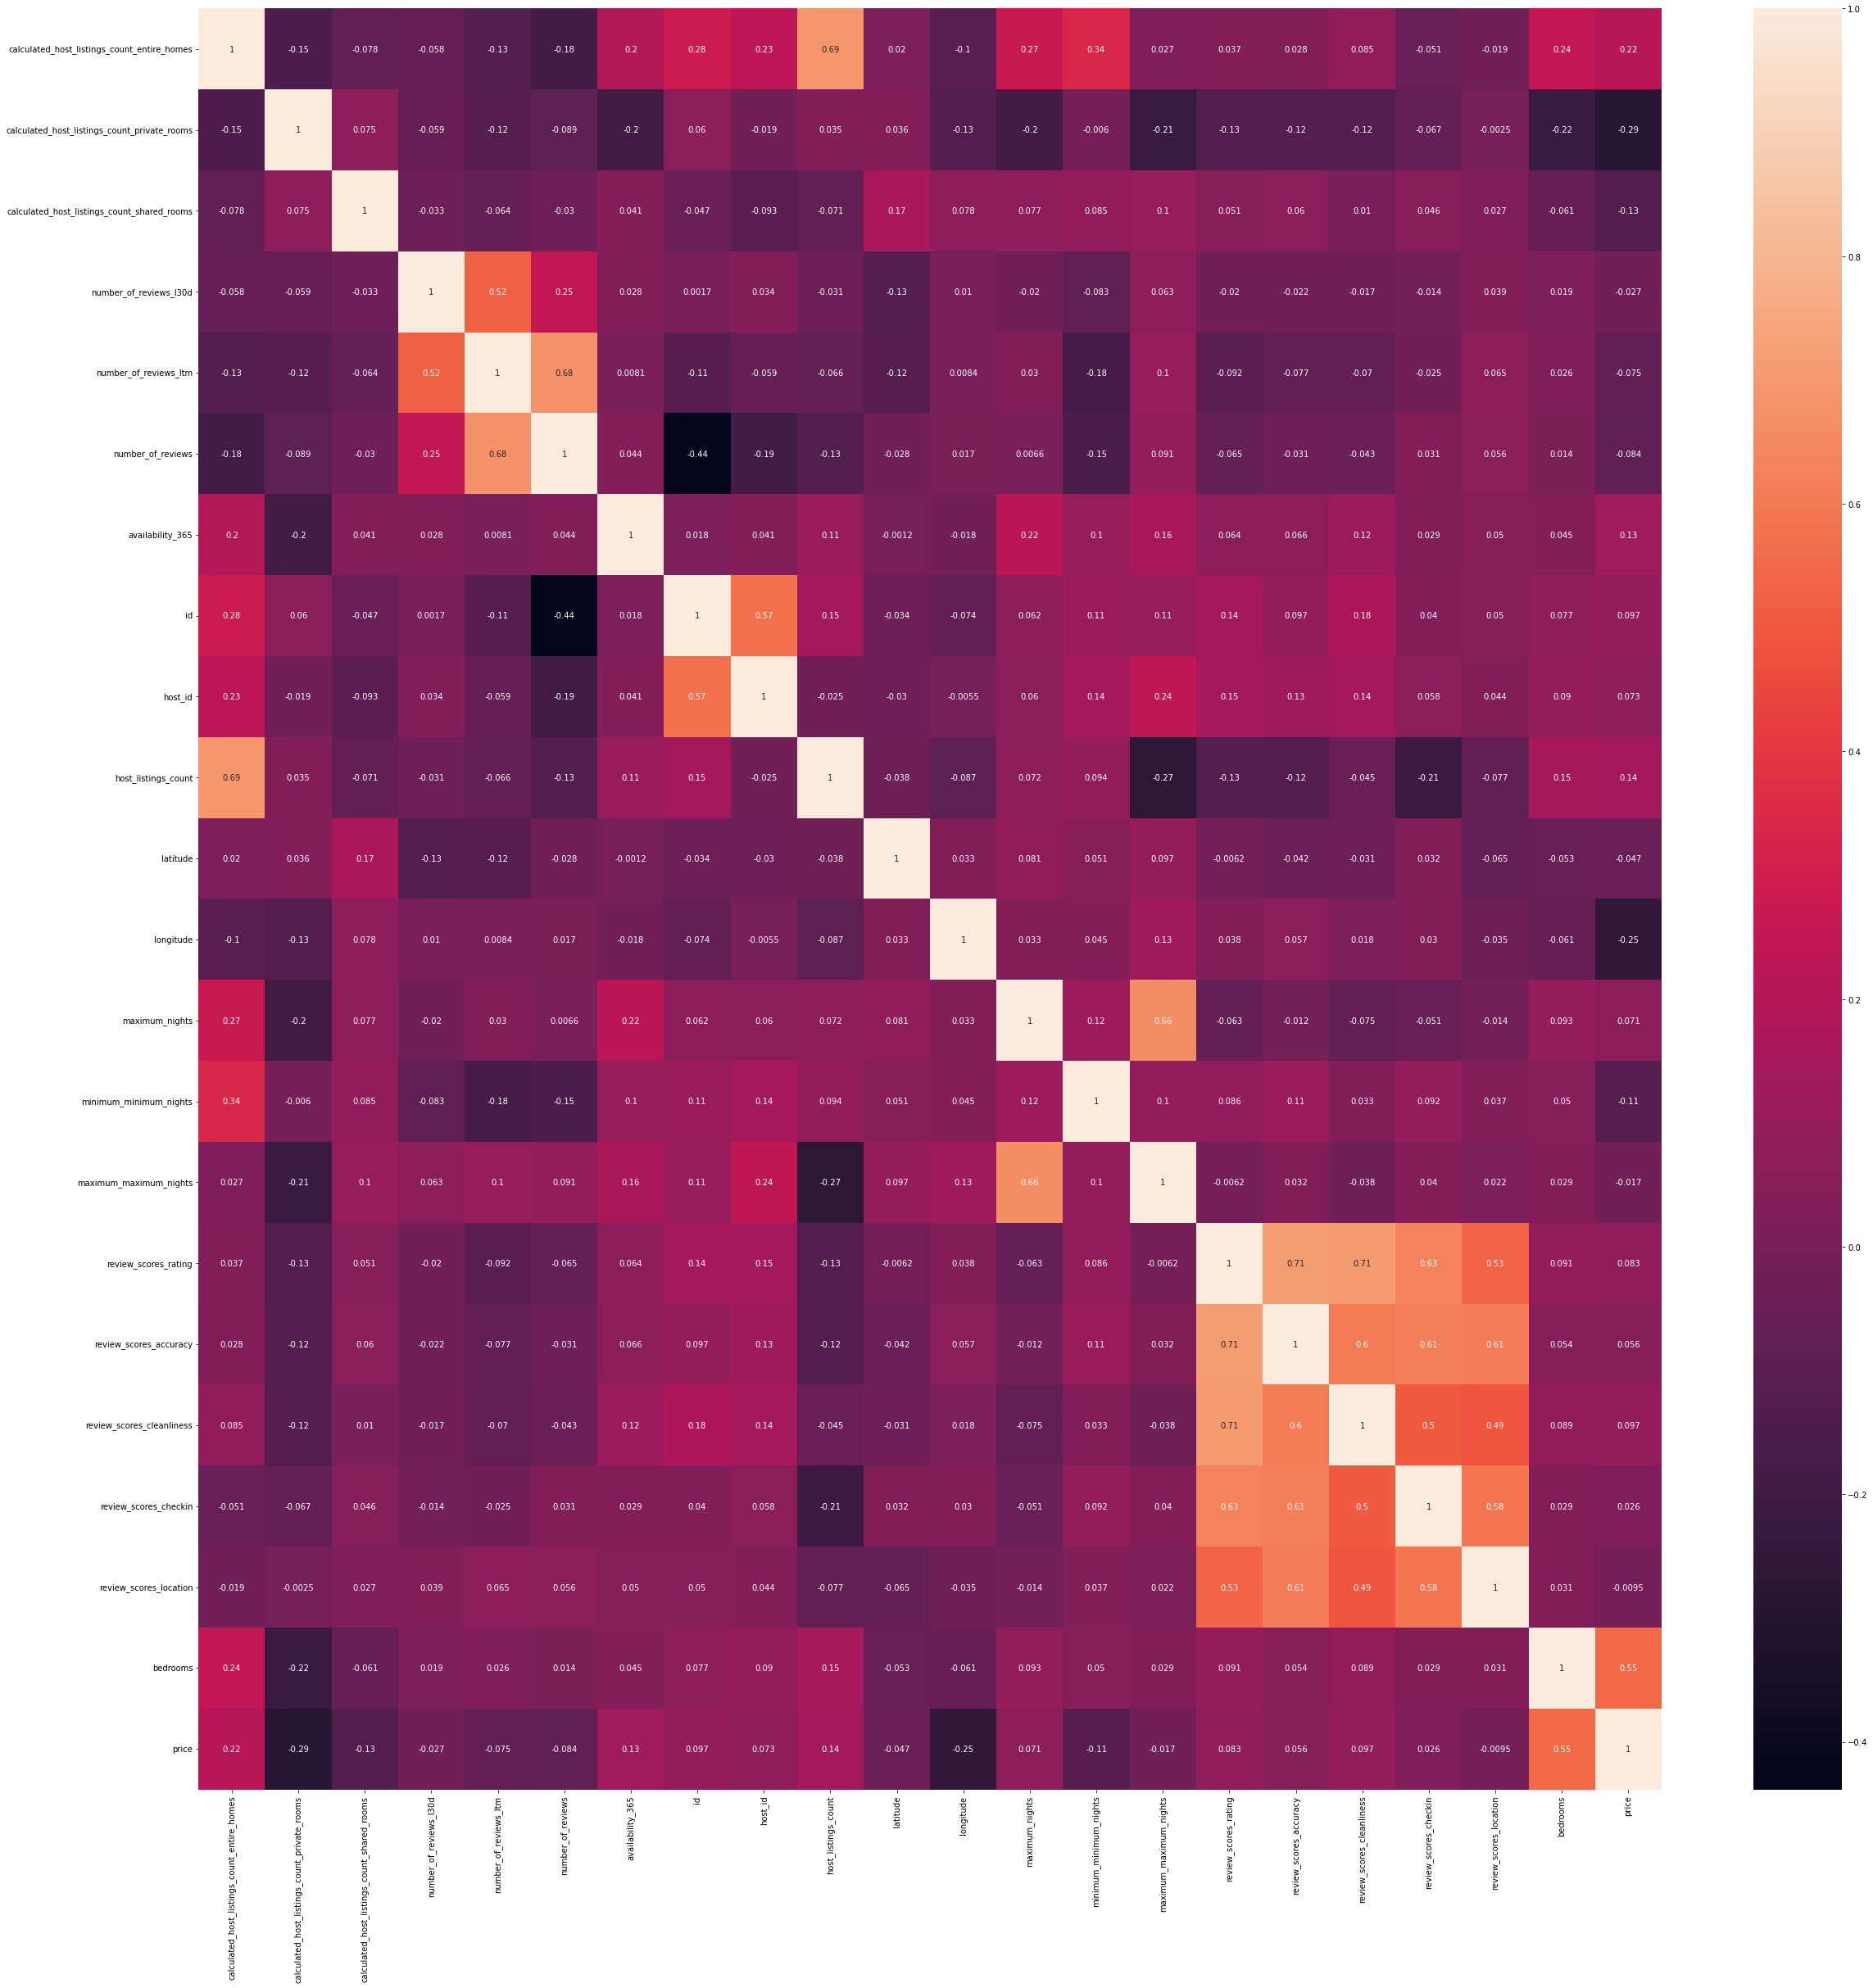

In [675]:
ax, fig = plt.subplots(figsize=(40,40))
sns.heatmap(df_num.corr(),annot=True)
plt.show()

In [676]:
df = pd.concat([df_cat,df_num], axis = 1)
df

,listing_url,last_scraped,name,description,neighborhood_overview,picture_url,host_url,host_name,host_since,host_location,...,maximum_nights,minimum_minimum_nights,maximum_maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_location,bedrooms,price
0,https://www.airbnb.com/rooms/47957,2020-12-18,"Amazing Apartment, Salamanca Distri",<b>The space</b><br />Totally remodeled modern...,Missing,https://a0.muscache.com/pictures/463140/d47b22...,https://www.airbnb.com/users/show/218515,Sergio,2010-08-31,United States,...,999.0,10.0,999.0,97.0,10.0,10.0,10.0,10.0,2.0,4.406719
1,https://www.airbnb.com/rooms/82481,2020-12-18,"Retiro Park, Stay at cosy studio","Studio inside house, but independent from it. ...",Missing,https://a0.muscache.com/pictures/580935/ddc661...,https://www.airbnb.com/users/show/448981,Mercedes,2011-03-18,"Madrid, Madrid, Spain",...,365.0,3.0,365.0,96.0,9.0,10.0,10.0,10.0,1.0,4.143135
2,https://www.airbnb.com/rooms/200828,2020-12-18,"FRENTE MAR, ZONA CALAS. PISCINA.",SITUADO EN UNA LADERA DE LA MONTAÑA QUE HAY FR...,es la unica sierra virgen no edificada del med...,https://a0.muscache.com/pictures/28820474-9bcd...,https://www.airbnb.com/users/show/75944,Maite,2010-01-31,"Peniscola, Valencian Community, Spain",...,1125.0,7.0,1125.0,100.0,10.0,10.0,10.0,10.0,2.0,5.365976
3,https://www.airbnb.com/rooms/282715,2020-12-18,"Cozy and Luxury Penthouse, GL*****Madrid",En una de las calles mas prestigiosas del mara...,"Se puede caminar hasta el impresionante ""Parqu...",https://a0.muscache.com/pictures/23416514/9c2a...,https://www.airbnb.com/users/show/1473247,Marta,2011-12-05,"Madrid, Madrid, Spain",...,365.0,2.0,365.0,97.0,10.0,10.0,10.0,10.0,2.0,4.787492
4,https://www.airbnb.com/rooms/406341,2020-12-18,"Quiet downtown Madrid, nearby all","Exterior single room, with all you need to stu...",The property has lifelong neighbors and discre...,https://a0.muscache.com/pictures/60519829/2a3a...,https://www.airbnb.com/users/show/2024487,Fernando,2012-03-28,"Madrid, Madrid, Spain",...,180.0,3.0,180.0,99.0,10.0,10.0,10.0,10.0,1.0,3.218876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,https://www.airbnb.com/rooms/46811766,2020-12-19,Nuevo piso 03 barrio Salamanca,Piso a estrenar desde el 4 diciembre de 2020 q...,En plena calle de juan bravo en el mejor barri...,https://a0.muscache.com/pictures/45577d99-7147...,https://www.airbnb.com/users/show/48033079,Isaac,2015-11-03,"Madrid, Community of Madrid, Spain",...,365.0,1.0,365.0,100.0,10.0,10.0,10.0,10.0,1.0,4.382027
713,https://www.airbnb.com/rooms/46817041,2020-12-19,"NEW! Style, Design, Class & Elegance @ Goya/Re...","You will love this LUXURIOUS, STYLISH, recentl...","""BARRIO DE SALAMANCA/ RETIRO"" is Madrid’s most...",https://a0.muscache.com/pictures/1875ac3d-6ccf...,https://www.airbnb.com/users/show/378268743,Andrea,2020-12-04,"London, England, United Kingdom",...,1125.0,2.0,1125.0,100.0,10.0,10.0,10.0,10.0,2.0,3.610918
714,https://www.airbnb.com/rooms/46957921,2020-12-18,"x. ALCALÁ w/ VELÁZQUEZ, perfect COUPLES or WORK",Perfect apartment for a COUPLE GETAWAY in the ...,"In the center of Madrid, the apartment is loca...",https://a0.muscache.com/pictures/c7bf72a1-ad62...,https://www.airbnb.com/users/show/107141654,Leeways,2016-12-13,"Madrid, Comunidad de Madrid, Spain",...,30.0,3.0,30.0,100.0,10.0,10.0,10.0,10.0,1.0,4.753590
715,https://www.airbnb.com/rooms/47002661,2020-12-19,Bright Spacious Madrid Flat with Natural Light,Spacious Madrid flat with great natural light ...,Missing,https://a0.muscache.com/pictures/eafb9520-7a7b...,https://www.airbnb.com/users/show/147205419,Sally,2017-08-22,"Madrid, Community of Madrid, Spain",...,19.0,1.0,1125.0,100.0,10.0,10.0,10.0,10.0,1.0,2.890372


# ANALIZAR LAS VARIABLES

In [677]:
cacho2 = df.loc[:,'amenities':]

In [678]:
cacho1 = pd.concat([df.loc[:,:'bathrooms_text'],df['price']],axis = 1)
cacho1

,listing_url,last_scraped,name,description,neighborhood_overview,picture_url,host_url,host_name,host_since,host_location,...,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,bathrooms_text,price
0,https://www.airbnb.com/rooms/47957,2020-12-18,"Amazing Apartment, Salamanca Distri",<b>The space</b><br />Totally remodeled modern...,Missing,https://a0.muscache.com/pictures/463140/d47b22...,https://www.airbnb.com/users/show/218515,Sergio,2010-08-31,United States,...,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,Missing,Goya,Salamanca,Entire condominium,Entire home/apt,2 baths,4.406719
1,https://www.airbnb.com/rooms/82481,2020-12-18,"Retiro Park, Stay at cosy studio","Studio inside house, but independent from it. ...",Missing,https://a0.muscache.com/pictures/580935/ddc661...,https://www.airbnb.com/users/show/448981,Mercedes,2011-03-18,"Madrid, Madrid, Spain",...,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,Missing,Recoletos,Salamanca,Entire apartment,Entire home/apt,1 bath,4.143135
2,https://www.airbnb.com/rooms/200828,2020-12-18,"FRENTE MAR, ZONA CALAS. PISCINA.",SITUADO EN UNA LADERA DE LA MONTAÑA QUE HAY FR...,es la unica sierra virgen no edificada del med...,https://a0.muscache.com/pictures/28820474-9bcd...,https://www.airbnb.com/users/show/75944,Maite,2010-01-31,"Peniscola, Valencian Community, Spain",...,"['email', 'phone', 'facebook', 'reviews']",t,f,"Madrid, Spain",Castellana,Salamanca,Entire apartment,Entire home/apt,1 bath,5.365976
3,https://www.airbnb.com/rooms/282715,2020-12-18,"Cozy and Luxury Penthouse, GL*****Madrid",En una de las calles mas prestigiosas del mara...,"Se puede caminar hasta el impresionante ""Parqu...",https://a0.muscache.com/pictures/23416514/9c2a...,https://www.airbnb.com/users/show/1473247,Marta,2011-12-05,"Madrid, Madrid, Spain",...,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,"Madrid, Spain",Recoletos,Salamanca,Entire apartment,Entire home/apt,2 baths,4.787492
4,https://www.airbnb.com/rooms/406341,2020-12-18,"Quiet downtown Madrid, nearby all","Exterior single room, with all you need to stu...",The property has lifelong neighbors and discre...,https://a0.muscache.com/pictures/60519829/2a3a...,https://www.airbnb.com/users/show/2024487,Fernando,2012-03-28,"Madrid, Madrid, Spain",...,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Madrid, Spain",Lista,Salamanca,Private room in apartment,Private room,1.5 baths,3.218876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,https://www.airbnb.com/rooms/46811766,2020-12-19,Nuevo piso 03 barrio Salamanca,Piso a estrenar desde el 4 diciembre de 2020 q...,En plena calle de juan bravo en el mejor barri...,https://a0.muscache.com/pictures/45577d99-7147...,https://www.airbnb.com/users/show/48033079,Isaac,2015-11-03,"Madrid, Community of Madrid, Spain",...,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Madrid, Comunidad de Madrid, Spain",Lista,Salamanca,Entire apartment,Entire home/apt,1.5 baths,4.382027
713,https://www.airbnb.com/rooms/46817041,2020-12-19,"NEW! Style, Design, Class & Elegance @ Goya/Re...","You will love this LUXURIOUS, STYLISH, recentl...","""BARRIO DE SALAMANCA/ RETIRO"" is Madrid’s most...",https://a0.muscache.com/pictures/1875ac3d-6ccf...,https://www.airbnb.com/users/show/378268743,Andrea,2020-12-04,"London, England, United Kingdom",...,['phone'],t,f,"Madrid, Comunidad de Madrid, Spain",Goya,Salamanca,Entire apartment,Entire home/apt,1 bath,3.610918
714,https://www.airbnb.com/rooms/46957921,2020-12-18,"x. ALCALÁ w/ VELÁZQUEZ, perfect COUPLES or WORK",Perfect apartment for a COUPLE GETAWAY in the ...,"In the center of Madrid, the apartment is loca...",https://a0.muscache.com/pictures/c7bf72a1-ad62...,https://www.airbnb.com/users/show/107141654,Leeways,2016-12-13,"Madrid, Comunidad de Madrid, Spain",...,"['email', 'phone', 'reviews', 'jumio', 'offlin..

In [680]:
cacho1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 716 entries, 0 to 716
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   listing_url                   716 non-null    object 
 1   last_scraped                  716 non-null    object 
 2   name                          716 non-null    object 
 3   description                   716 non-null    object 
 4   neighborhood_overview         716 non-null    object 
 5   picture_url                   716 non-null    object 
 6   host_url                      716 non-null    object 
 7   host_name                     716 non-null    object 
 8   host_since                    716 non-null    object 
 9   host_location                 716 non-null    object 
 10  host_about                    716 non-null    object 
 11  host_response_time            716 non-null    object 
 12  host_response_rate            716 non-null    object 
 13  host_

In [681]:
#Vamos a cargarnos variables que no tienen sentido
deletear = ['listing_url','last_scraped','name','description','neighborhood_overview','picture_url','host_url','host_name','host_since','host_about','host_thumbnail_url','host_picture_url','host_verifications']
for i in deletear:
    del cacho1[i]
cacho1

,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,bathrooms_text,price
0,United States,Missing,Missing,Missing,f,Goya,t,t,Missing,Goya,Salamanca,Entire condominium,Entire home/apt,2 baths,4.406719
1,"Madrid, Madrid, Spain",Missing,Missing,Missing,f,Recoletos,t,t,Missing,Recoletos,Salamanca,Entire apartment,Entire home/apt,1 bath,4.143135
2,"Peniscola, Valencian Community, Spain",Missing,Missing,0%,f,Castellana,t,f,"Madrid, Spain",Castellana,Salamanca,Entire apartment,Entire home/apt,1 bath,5.365976
3,"Madrid, Madrid, Spain",within a few hours,100%,92%,t,Recoletos,t,t,"Madrid, Spain",Recoletos,Salamanca,Entire apartment,Entire home/apt,2 baths,4.787492
4,"Madrid, Madrid, Spain",within a few hours,100%,92%,t,Goya,t,t,"Madrid, Spain",Lista,Salamanca,Private room in apartment,Private room,1.5 baths,3.218876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,"Madrid, Community of Madrid, Spain",within an hour,99%,100%,f,Delicias,t,t,"Madrid, Comunidad de Madrid, Spain",Lista,Salamanca,Entire apartment,Entire home/apt,1.5 baths,4.382027
713,"London, England, United Kingdom",within a few hours,100%,Missing,f,Missing,t,f,"Madrid, Comunidad de Madrid, Spain",Goya,Salamanca,Entire apartment,Entire home/apt,1 bath,3.610918
714,"Madrid, Comunidad de Madrid, Spain",within an hour,99%,100%,f,Justicia,t,t,"Madrid, Comunidad de Madrid, Spain",Recoletos,Salamanca,Entire apartment,Entire home/apt,1 bath,4.753590
715,"Madrid, Community of Madrid, Spain",within a day,67%,100%,f,Missing,t,f,Missing,Lista,Salamanca,Private room in apartment,Private room,2.5 shared baths,2.890372


In [682]:
deletear = ['host_location','host_neighbourhood','neighbourhood_cleansed','property_type']
for i in deletear:
    del cacho1[i]
    
cacho1

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_group_cleansed,room_type,bathrooms_text,price
0,Missing,Missing,Missing,f,t,t,Missing,Salamanca,Entire home/apt,2 baths,4.406719
1,Missing,Missing,Missing,f,t,t,Missing,Salamanca,Entire home/apt,1 bath,4.143135
2,Missing,Missing,0%,f,t,f,"Madrid, Spain",Salamanca,Entire home/apt,1 bath,5.365976
3,within a few hours,100%,92%,t,t,t,"Madrid, Spain",Salamanca,Entire home/apt,2 baths,4.787492
4,within a few hours,100%,92%,t,t,t,"Madrid, Spain",Salamanca,Private room,1.5 baths,3.218876
...,...,...,...,...,...,...,...,...,...,...,...
712,within an hour,99%,100%,f,t,t,"Madrid, Comunidad de Madrid, Spain",Salamanca,Entire home/apt,1.5 baths,4.382027
713,within a few hours,100%,Missing,f,t,f,"Madrid, Comunidad de Madrid, Spain",Salamanca,Entire home/apt,1 bath,3.610918
714,within an hour,99%,100%,f,t,t,"Madrid, Comunidad de Madrid, Spain",Salamanca,Entire home/apt,1 bath,4.753590
715,within a day,67%,100%,f,t,f,Missing,Salamanca,Private room,2.5 shared baths,2.890372


In [683]:
cacho1.isnull().sum()

host_response_time              0
host_response_rate              0
host_acceptance_rate            0
host_is_superhost               0
host_has_profile_pic            0
host_identity_verified          0
neighbourhood                   0
neighbourhood_group_cleansed    0
room_type                       0
bathrooms_text                  0
price                           0
dtype: int64

In [684]:
#Vamos a cambiar los rates
def change_rates(serie):
    rates = []
    for i in serie:
        if i == '100%':
            rates.append(i)
            continue
        if i == 'Missing':
            rates.append(i)
            continue
        if int(i.split('%')[0]) < 10:
            rates.append('0-10%')
            continue
        if int(i.split('%')[0]) < 20:
            rates.append('10-20%')
            continue
        if int(i.split('%')[0]) < 30:
            rates.append('20-30%')
            continue
        if int(i.split('%')[0]) < 40:
            rates.append('30-40%')
            continue
        if int(i.split('%')[0]) < 50:
            rates.append('40-50%')
            continue
        if int(i.split('%')[0]) < 60:
            rates.append('50-60%')
            continue
        if int(i.split('%')[0]) < 70:
            rates.append('60-70%')
            continue
        if int(i.split('%')[0]) < 80:
            rates.append('70-80%')
            continue
        if int(i.split('%')[0]) < 90:
            rates.append('80-90%')
            continue
        if int(i.split('%')[0]) < 100:
            rates.append('90-100%')
            continue
    return rates     

In [685]:
cacho1['host_response_rate'] = change_rates(cacho1['host_response_rate'])

In [686]:
cacho1['host_acceptance_rate'] = change_rates(cacho1['host_acceptance_rate'])

In [687]:
# Cambiamos neighbourhood y bath_text por porcentajes
v = (cacho1.groupby('neighbourhood').count()['price']*100/cacho1.shape[0]).values
i = (cacho1.groupby('neighbourhood').count()['price']*100/cacho1.shape[0]).index
for j in range(len(i)):
    cacho1['neighbourhood'].replace(i[j],v[j], inplace=True)
cacho1['neighbourhood']

0      28.351955
1      28.351955
2       3.491620
3       3.491620
4       3.491620
         ...    
712    65.363128
713    65.363128
714    65.363128
715    28.351955
716    28.351955
Name: neighbourhood, Length: 716, dtype: float64

In [688]:
# Cambiamos neighbourhood y bath_text por porcentajes
v = (cacho1.groupby('bathrooms_text').count()['price']*100/cacho1.shape[0]).values
i = (cacho1.groupby('bathrooms_text').count()['price']*100/cacho1.shape[0]).index
for j in range(len(i)):
    cacho1['bathrooms_text'].replace(i[j],v[j], inplace=True)
cacho1['bathrooms_text']

0      27.653631
1      35.754190
2      35.754190
3      27.653631
4       5.446927
         ...    
712     5.446927
713    35.754190
714    35.754190
715     0.698324
716    35.754190
Name: bathrooms_text, Length: 716, dtype: float64

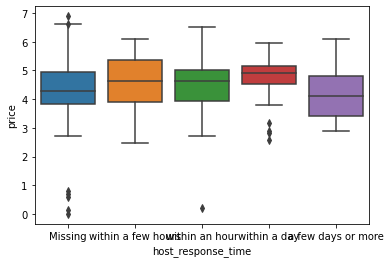

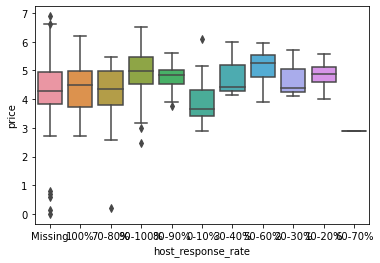

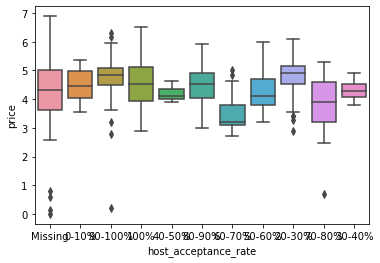

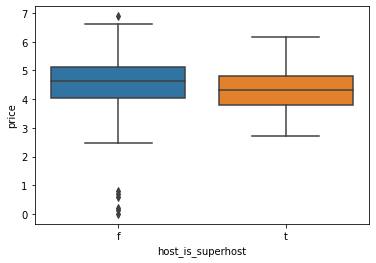

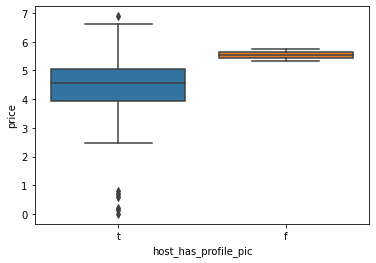

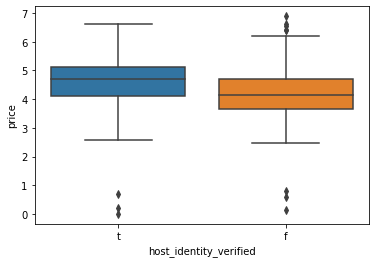

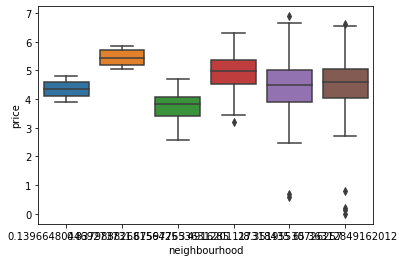

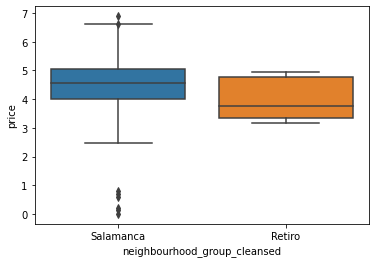

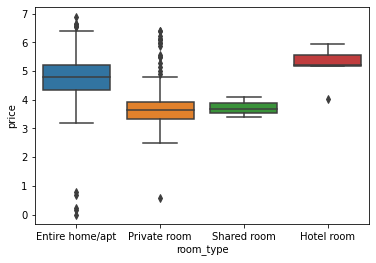

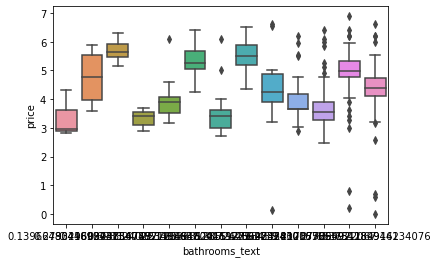

In [689]:
for i in list(cacho1.columns[:-1]):
    sns.boxplot(x = i, y = 'price', data = cacho1)
    plt.show()

In [690]:
#Sacamos las dummies de las variables que se han quedado categoricas
cacho1 = pd.get_dummies(cacho1,drop_first=True)
cacho1

,neighbourhood,bathrooms_text,price,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_rate_10-20%,host_response_rate_100%,host_response_rate_20-30%,...,host_acceptance_rate_80-90%,host_acceptance_rate_90-100%,host_acceptance_rate_Missing,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,neighbourhood_group_cleansed_Salamanca,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,28.351955,27.653631,4.406719,0,0,0,0,0,0,0,...,0,0,1,0,1,1,1,0,0,0
1,28.351955,35.754190,4.143135,0,0,0,0,0,0,0,...,0,0,1,0,1,1,1,0,0,0
2,3.491620,35.754190,5.365976,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,3.491620,27.653631,4.787492,0,0,1,0,0,1,0,...,0,1,0,1,1,1,1,0,0,0
4,3.491620,5.446927,3.218876,0,0,1,0,0,1,0,...,0,1,0,1,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,65.363128,5.446927,4.382027,0,0,0,1,0,0,0,...,0,0,0,0,1,1,1,0,0,0
713,65.363128,35.754190,3.610918,0,0,1,0,0,1,0,...,0,0,1,0,1,0,1,0,0,0
714,65.363128,35.754190,4.753590,0,0,0,1,0,0,0,...,0,0,0,0,1,1,1,0,0,0
715,28.351955,0.698324,2.890372,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0


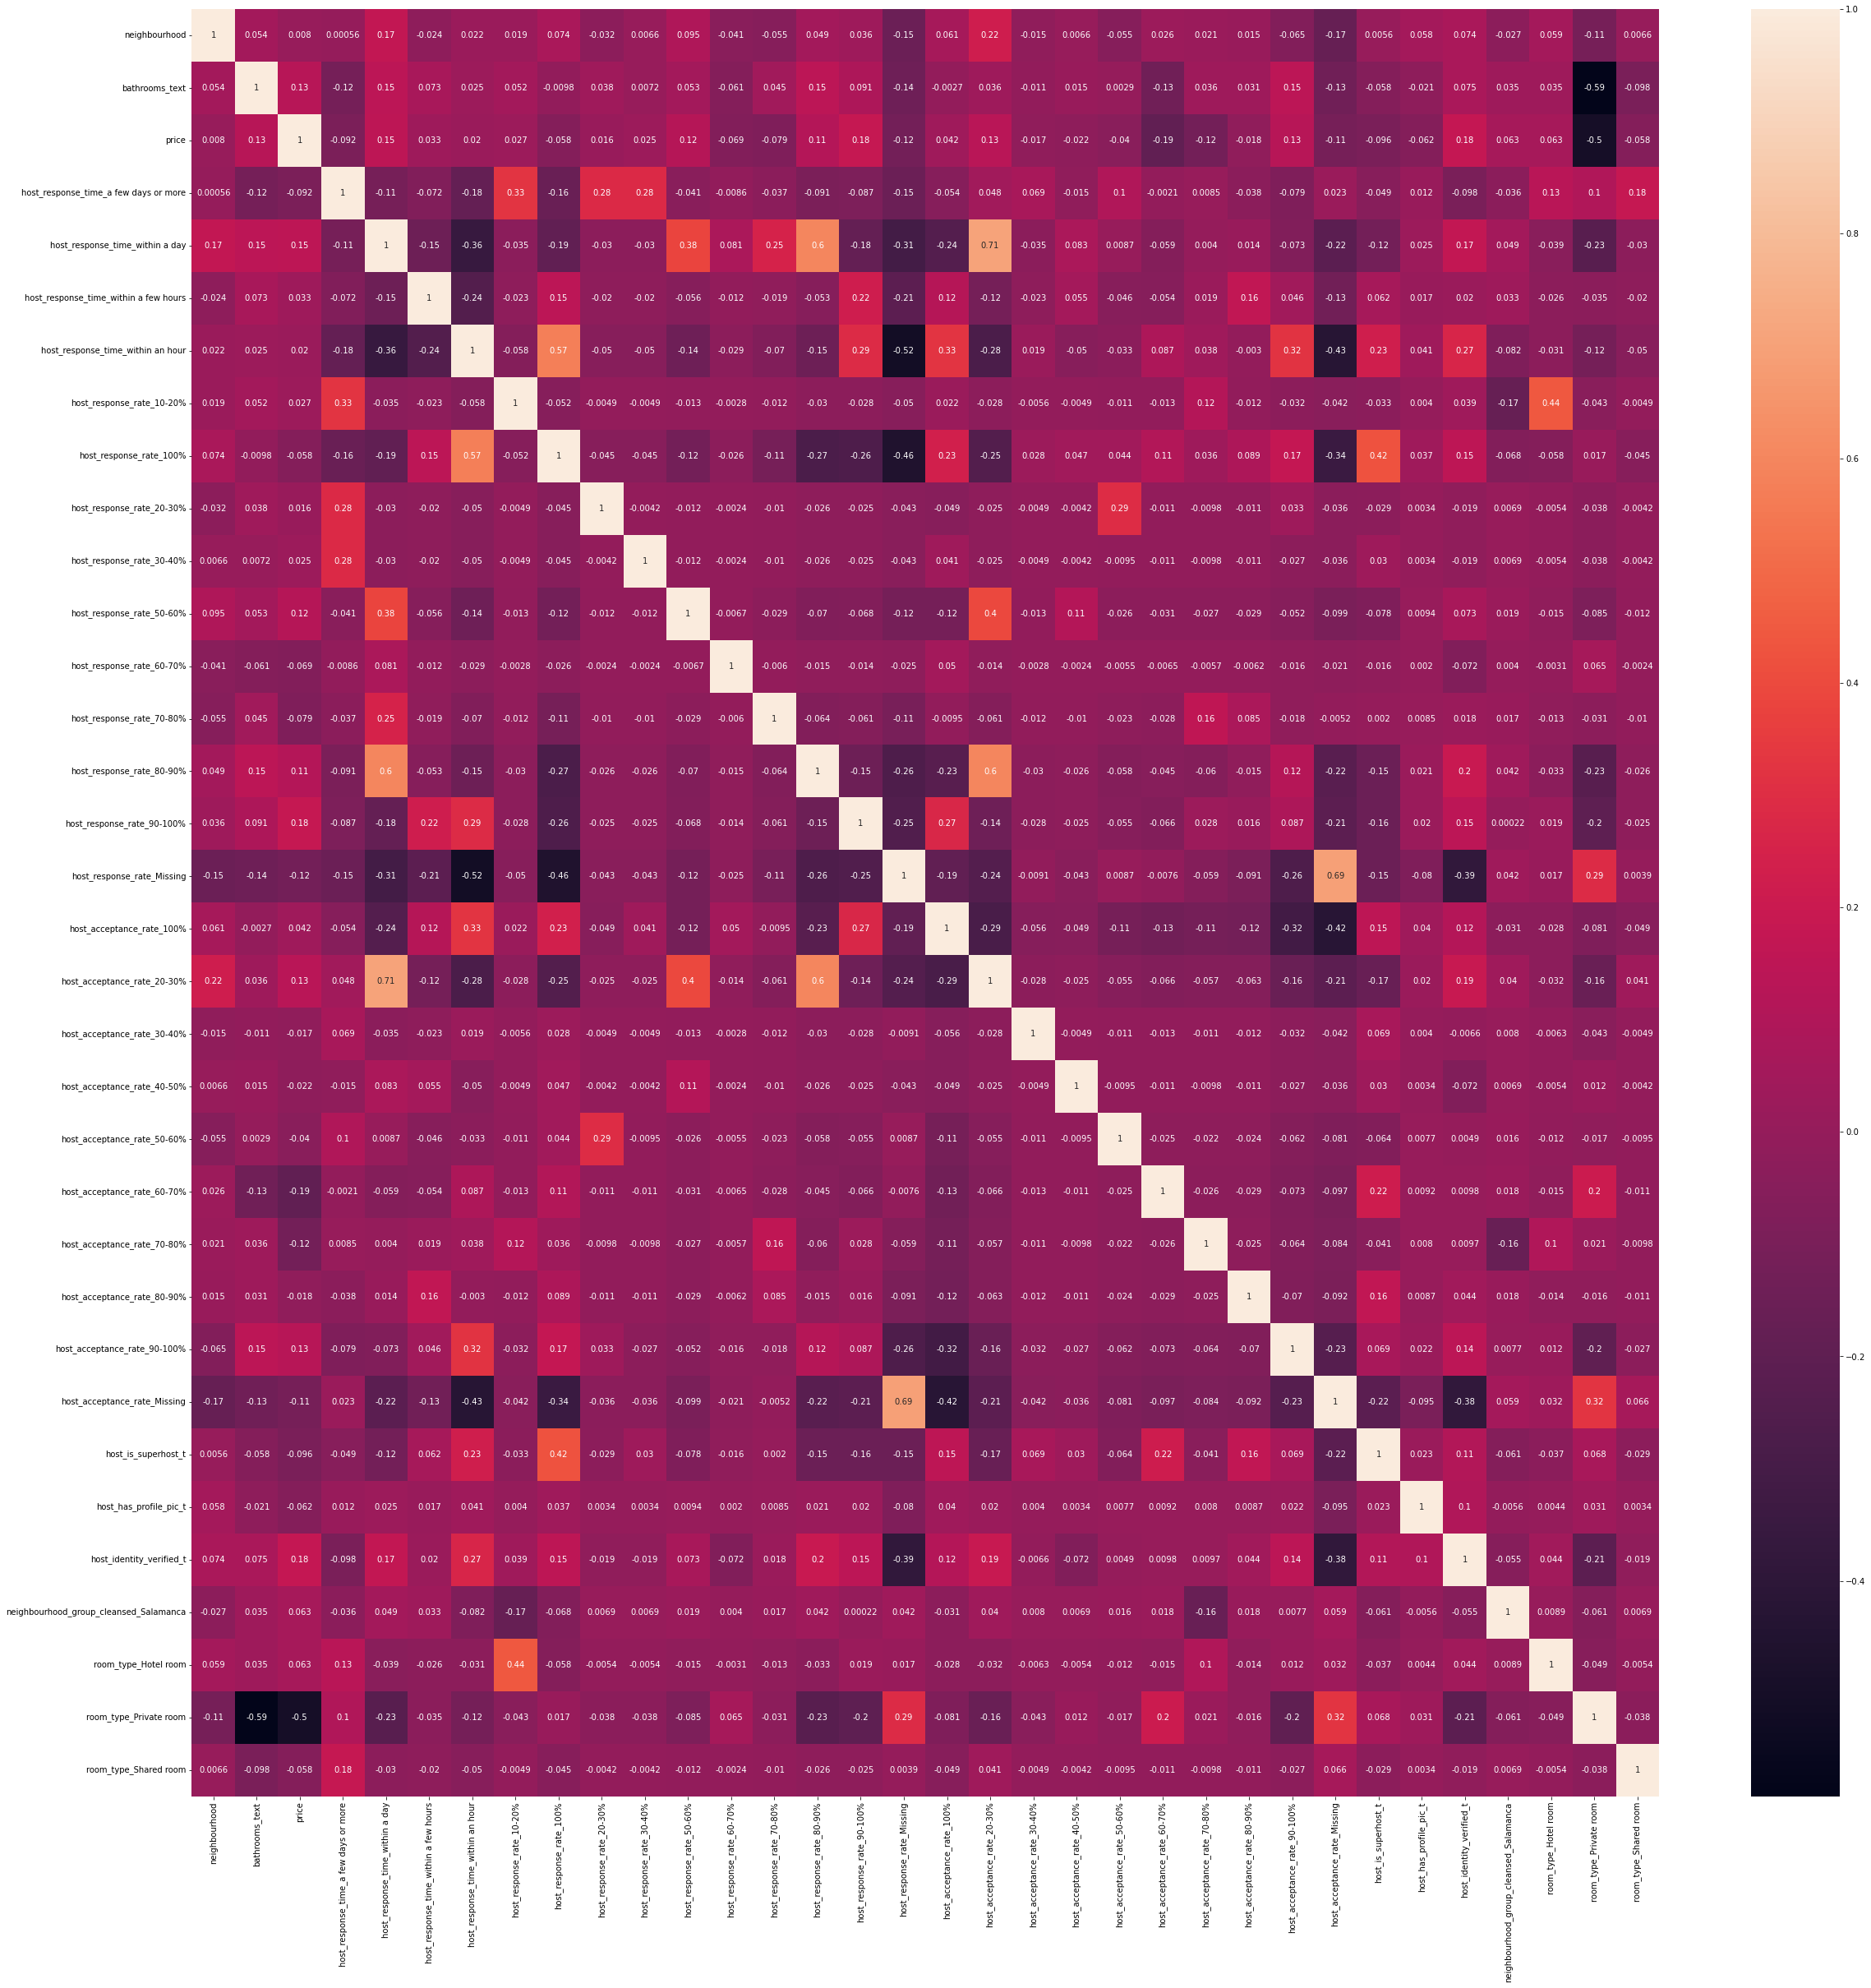

In [691]:
ax, fig = plt.subplots(figsize=(40,40))
sns.heatmap(cacho1.corr(),annot=True)
plt.show()

In [692]:
eliminar = ['license','host_id','longitude', 'latitude', 'calendar_last_scraped', 'first_review', 'last_review']
for i in eliminar:
    del cacho2[i]

In [693]:
cacho2.reset_index(inplace = True)
del cacho2['index']

In [694]:
lista =[]
for i in range(len(cacho2['amenities'])):
    lista.append(len(cacho2['amenities'][i].split(",")))
    
lista
cacho2["amenities"] = lista

In [695]:
cacho2

,amenities,has_availability,instant_bookable,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,number_of_reviews_l30d,number_of_reviews_ltm,number_of_reviews,availability_365,...,maximum_nights,minimum_minimum_nights,maximum_maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_location,bedrooms,price
0,20,t,f,2.0,0.0,0.0,0.0,0.0,55.0,362.0,...,999.0,10.0,999.0,97.0,10.0,10.0,10.0,10.0,2.0,4.406719
1,10,t,f,1.0,0.0,0.0,0.0,0.0,108.0,0.0,...,365.0,3.0,365.0,96.0,9.0,10.0,10.0,10.0,1.0,4.143135
2,1,t,f,1.0,0.0,0.0,0.0,0.0,0.0,365.0,...,1125.0,7.0,1125.0,100.0,10.0,10.0,10.0,10.0,2.0,5.365976
3,37,t,f,1.0,0.0,0.0,0.0,8.0,111.0,364.0,...,365.0,2.0,365.0,97.0,10.0,10.0,10.0,10.0,2.0,4.787492
4,28,t,f,0.0,1.0,0.0,0.0,7.0,124.0,195.0,...,180.0,3.0,180.0,99.0,10.0,10.0,10.0,10.0,1.0,3.218876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,20,t,t,29.0,0.0,0.0,0.0,0.0,0.0,180.0,...,365.0,1.0,365.0,100.0,10.0,10.0,10.0,10.0,1.0,4.382027
712,46,t,f,1.0,0.0,0.0,0.0,0.0,0.0,79.0,...,1125.0,2.0,1125.0,100.0,10.0,10.0,10.0,10.0,2.0,3.610918
713,25,t,t,72.0,0.0,0.0,0.0,0.0,0.0,356.0,...,30.0,3.0,30.0,100.0,10.0,10.0,10.0,10.0,1.0,4.753590
714,12,t,f,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,19.0,1.0,1125.0,100.0,10.0,10.0,10.0,10.0,1.0,2.890372


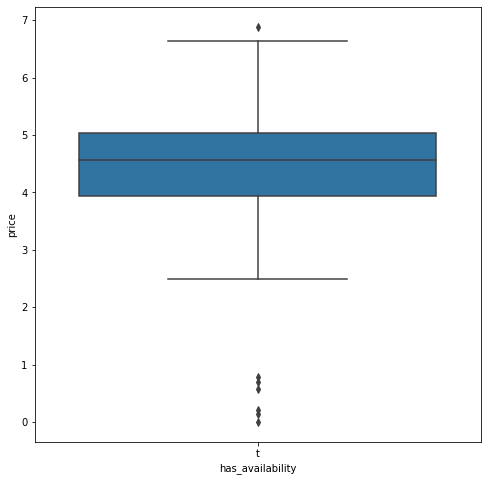

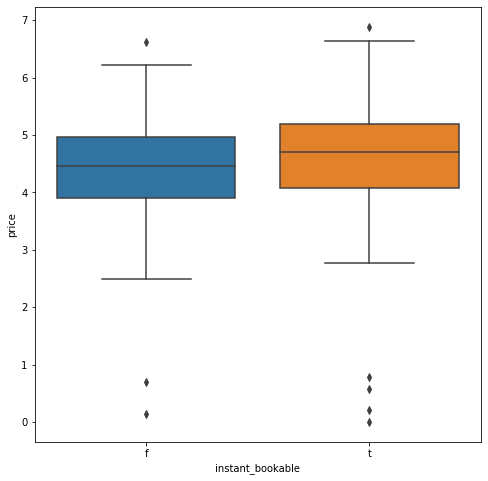

In [696]:
for i in cacho2.columns[1:3]:   
    ax, fig = plt.subplots(figsize=(8,8))
    sns.boxplot(x=i, y= 'price', data = cacho2)
    plt.show()

In [697]:
cacho2 = pd.get_dummies(cacho2, drop_first=True)

C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


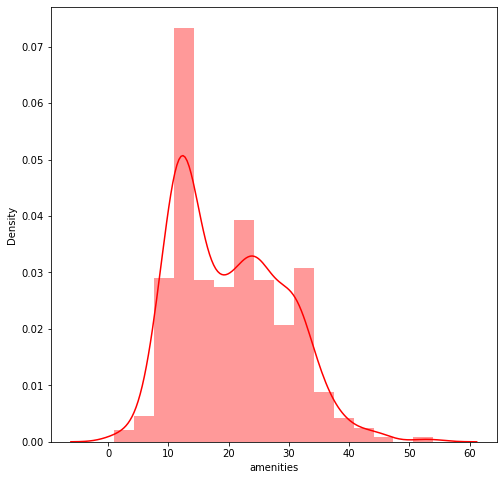

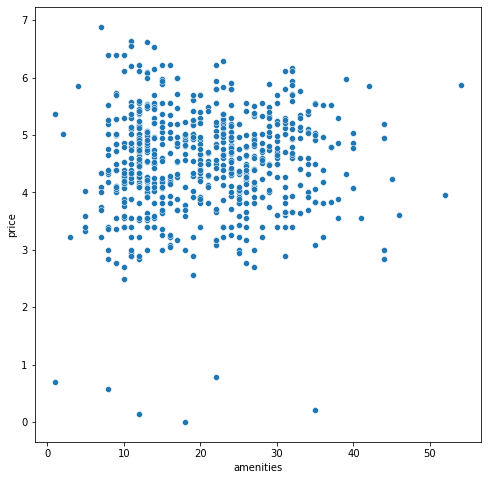

C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


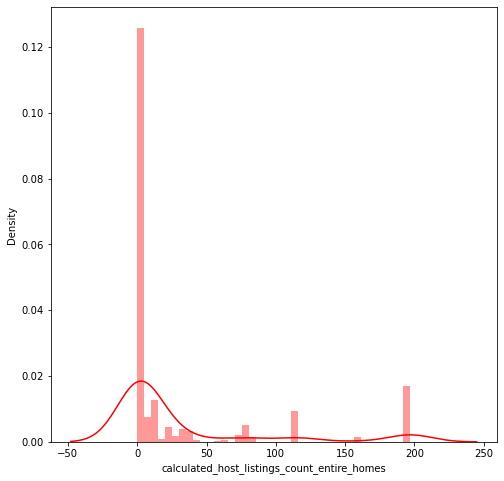

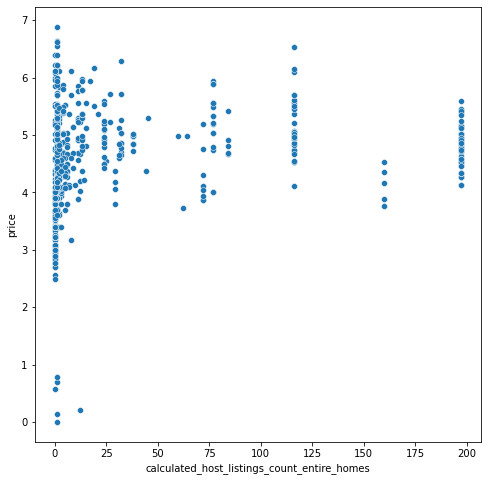

C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


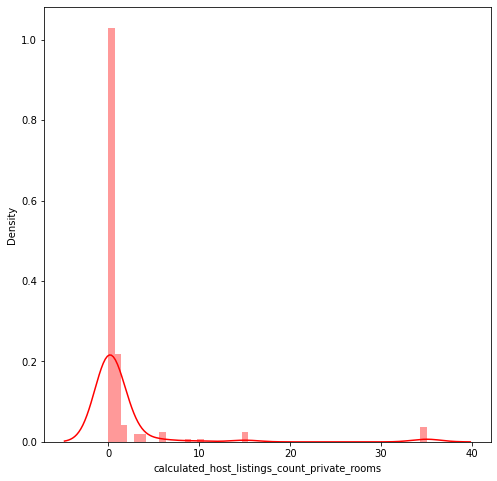

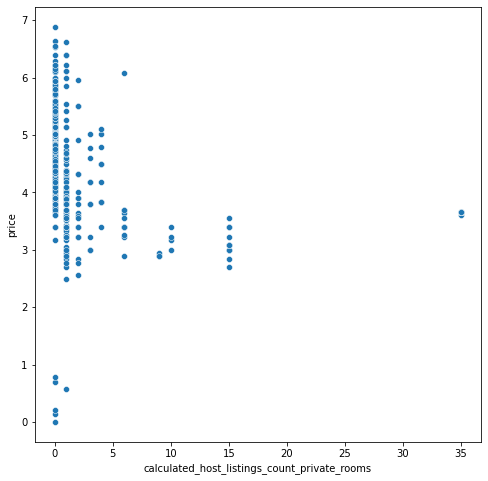

C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


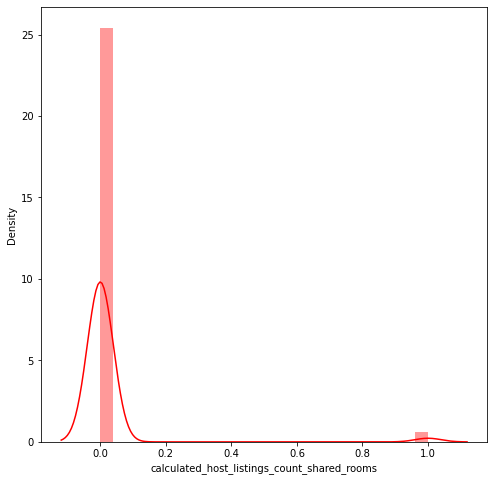

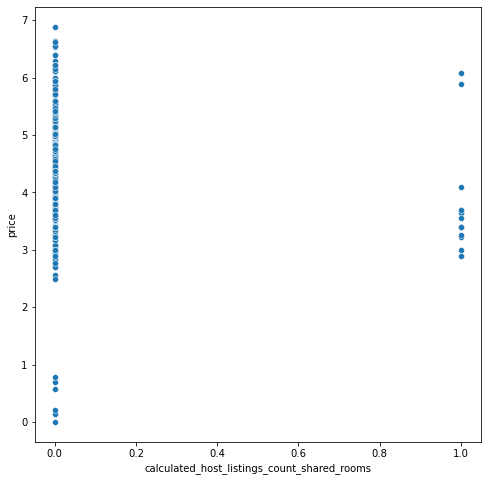

C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


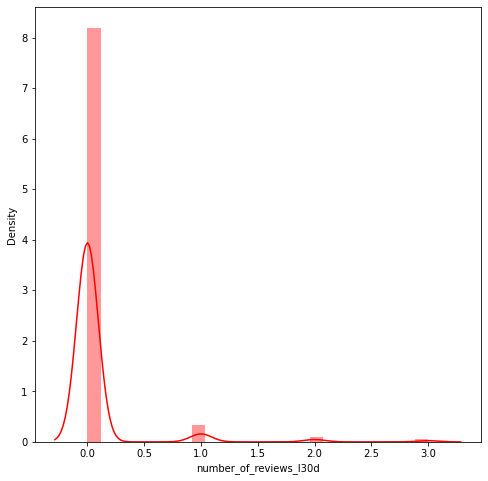

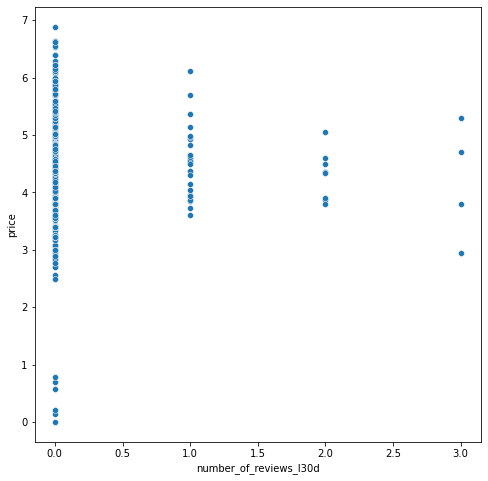

C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


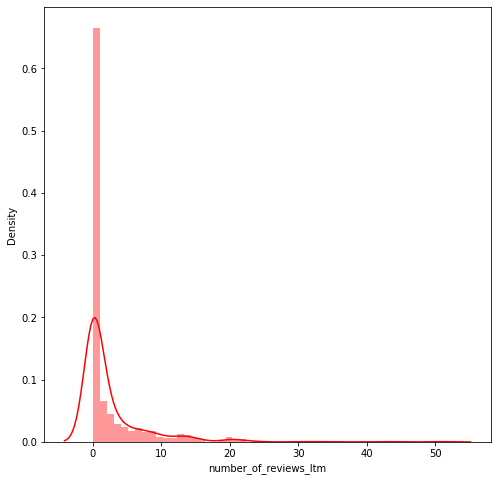

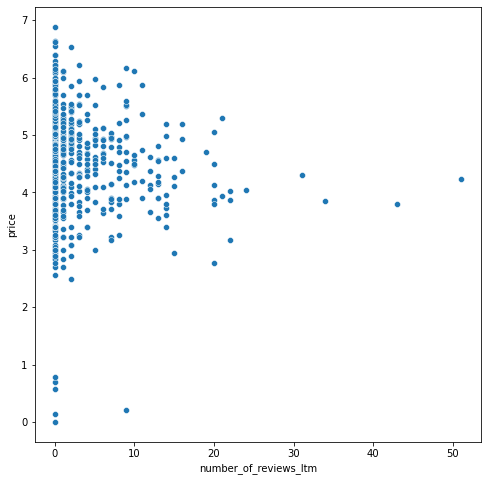

C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


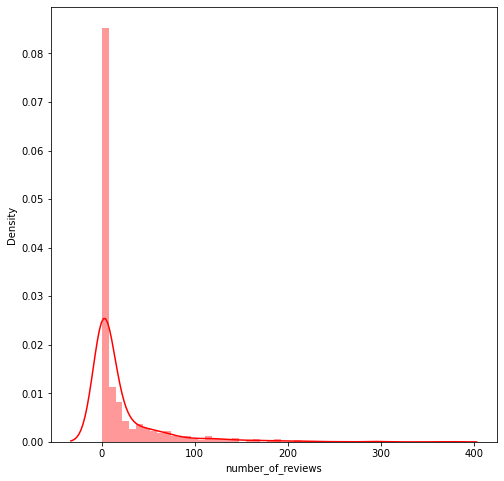

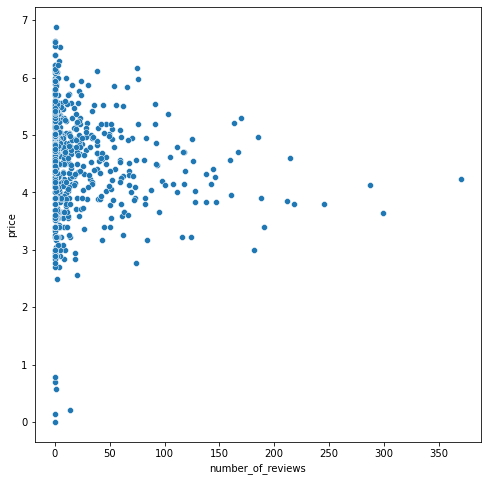

C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


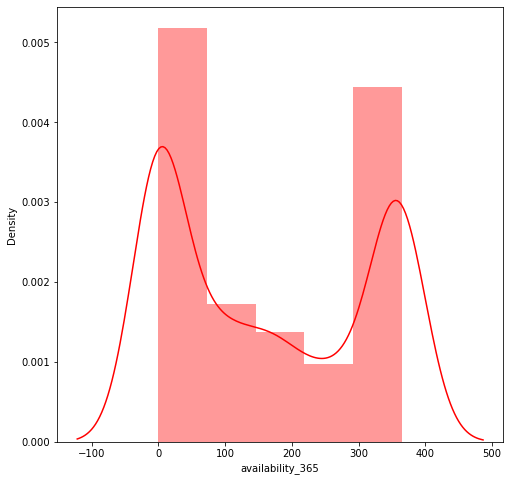

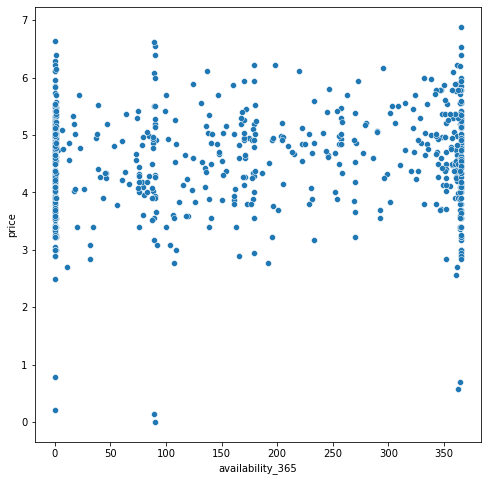

C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


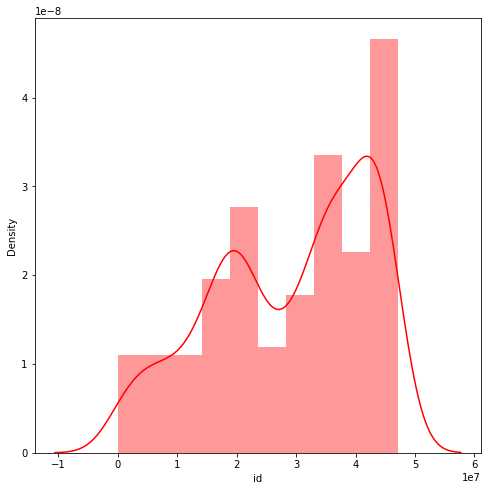

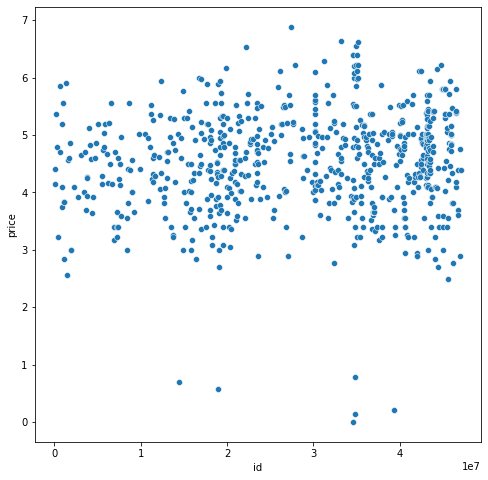

C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


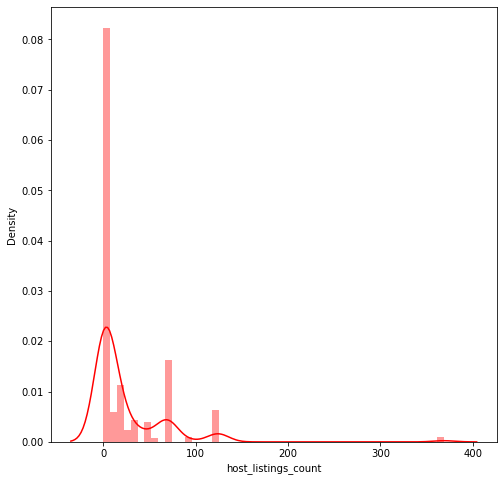

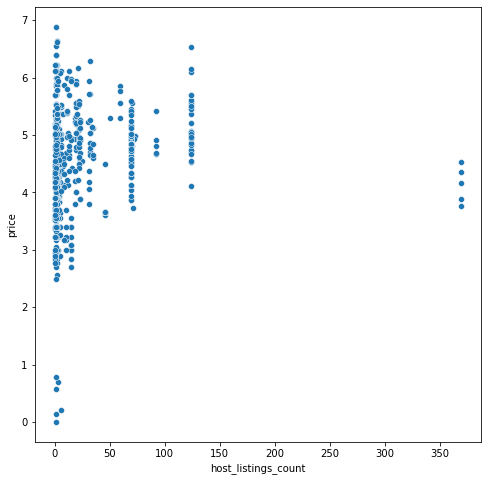

C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


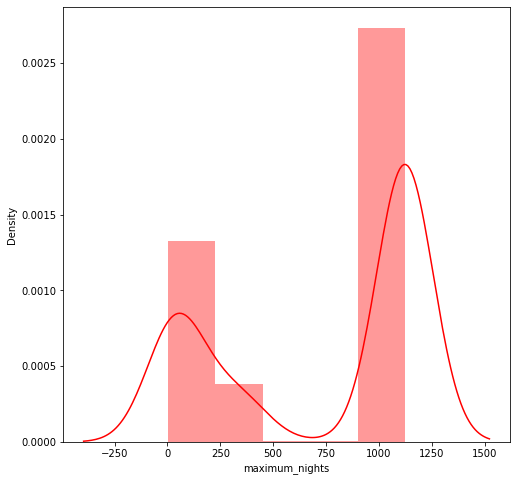

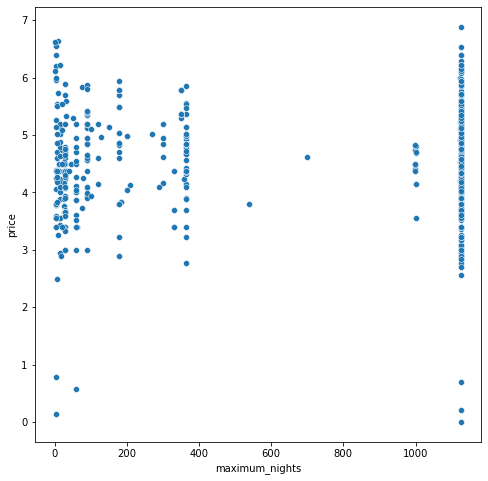

C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


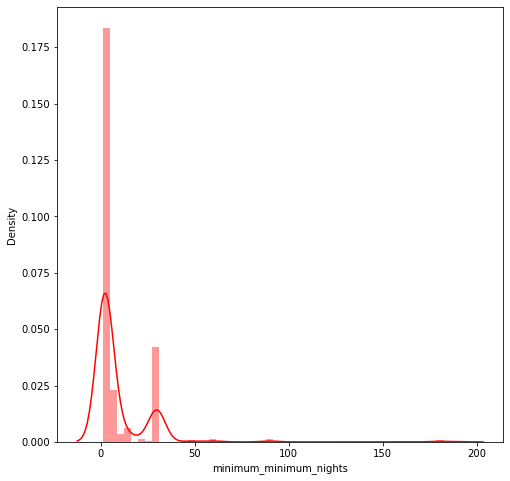

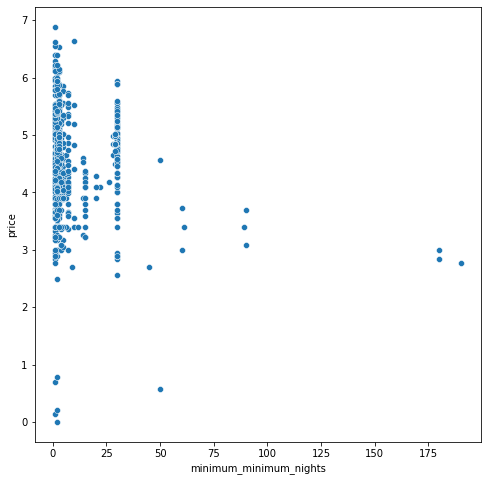

C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


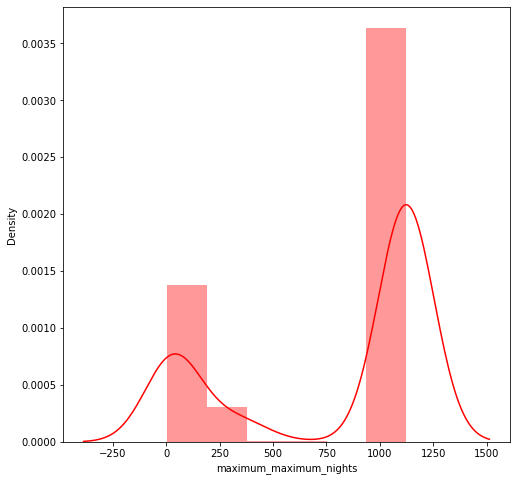

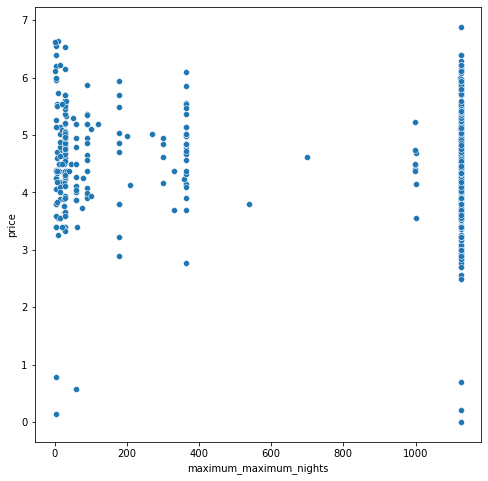

C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


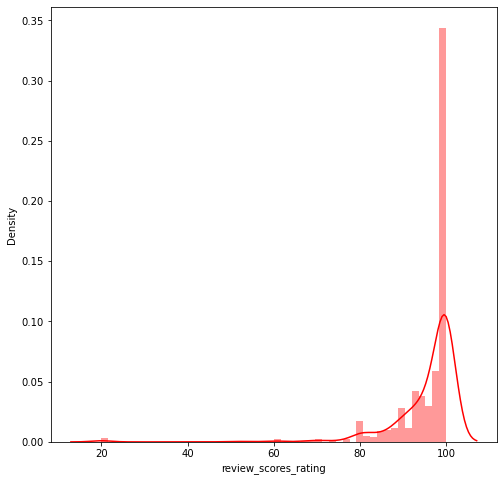

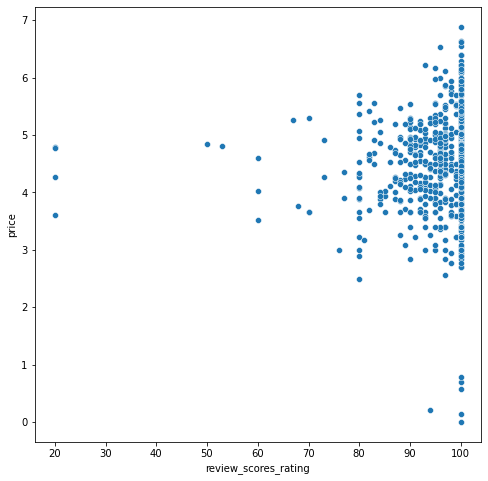

C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


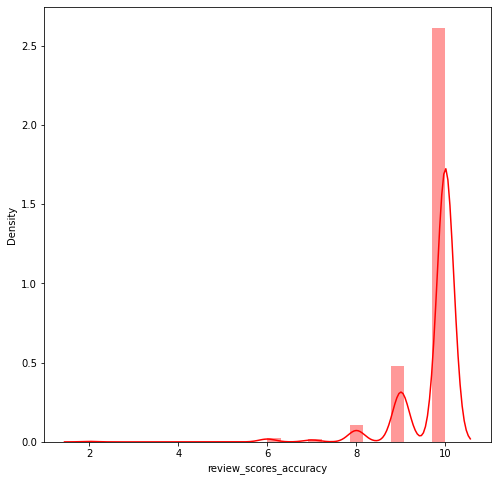

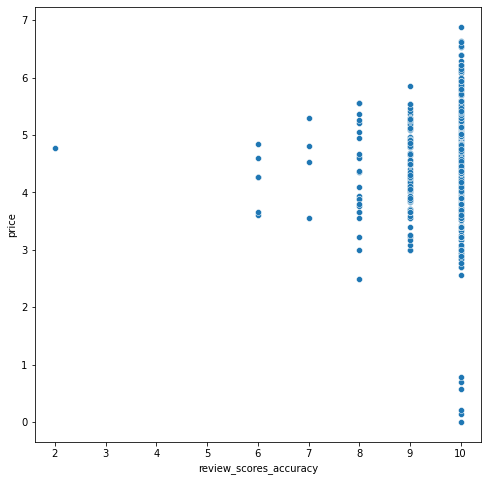

C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


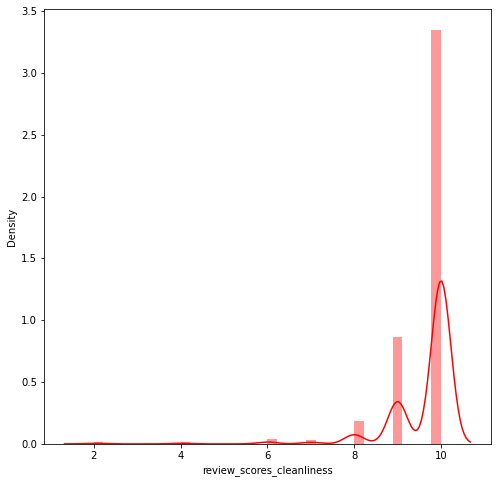

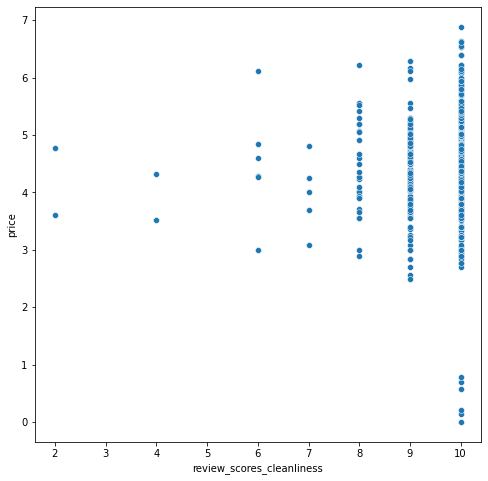

C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


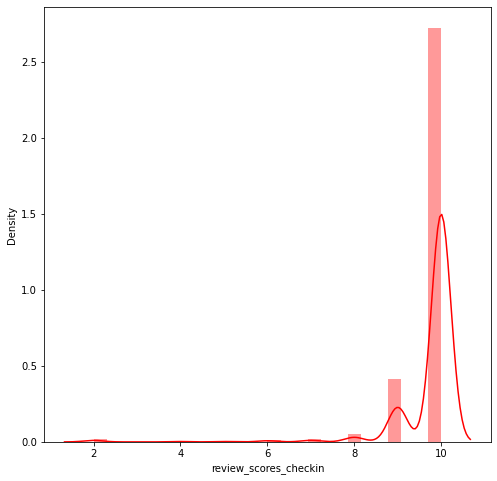

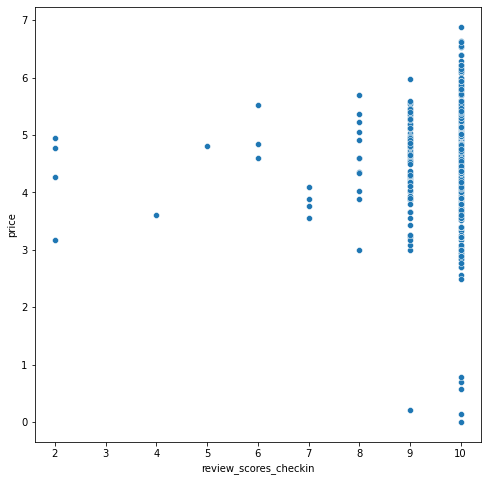

C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


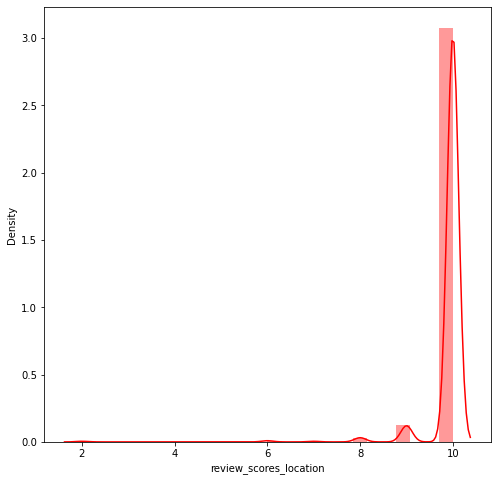

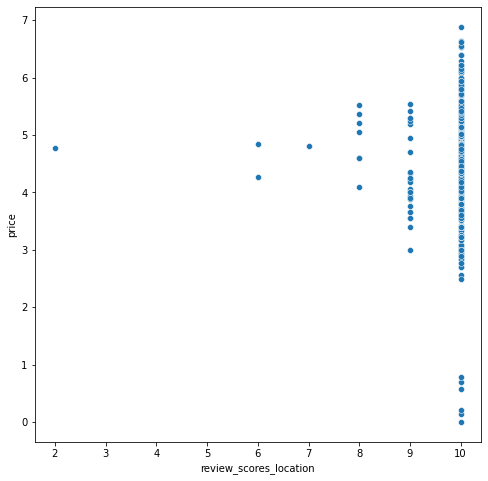

C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


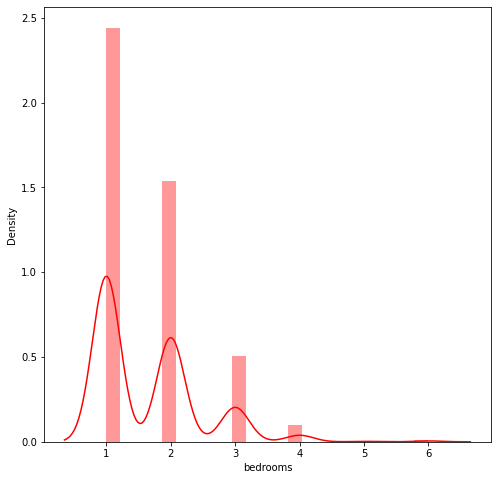

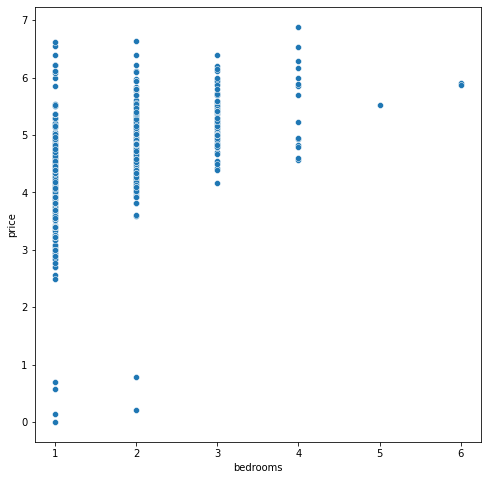

C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


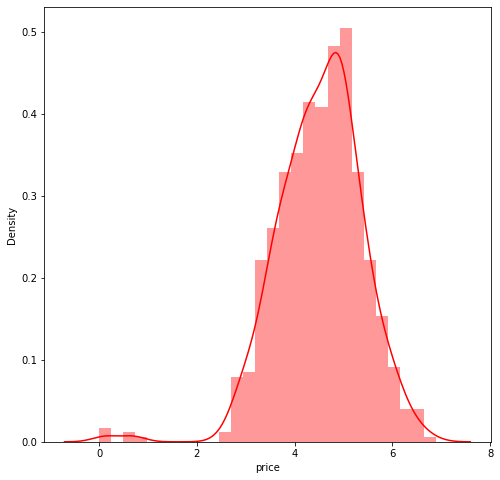

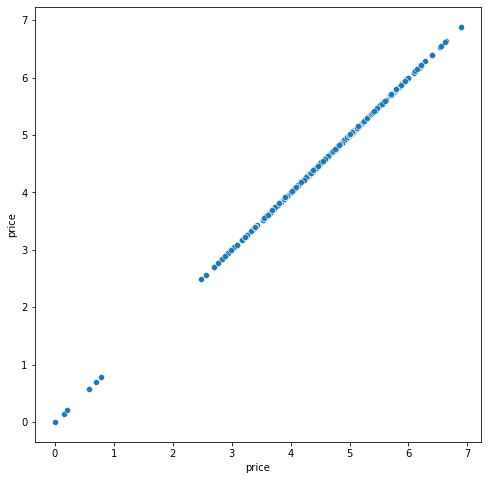

C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


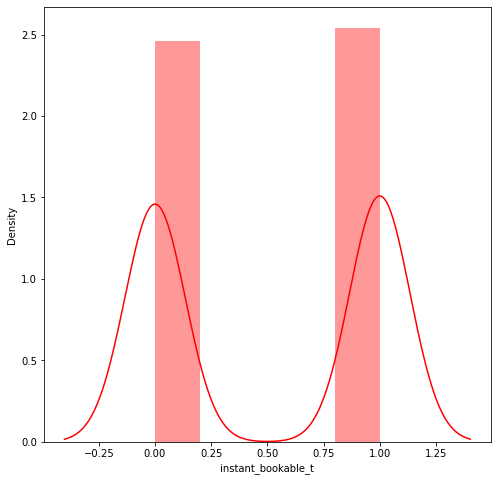

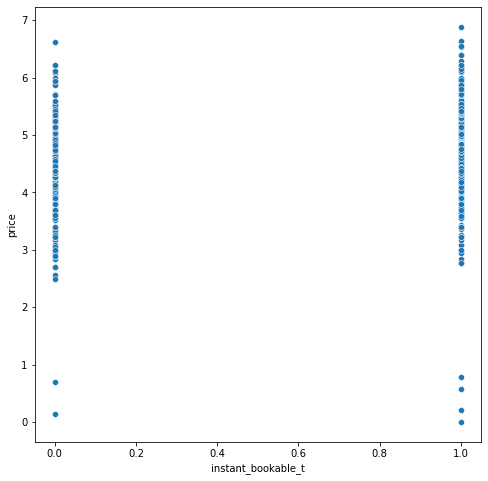

In [698]:
for i in cacho2.columns:   
    ax, fig = plt.subplots(figsize=(8,8))
    sns.distplot(cacho2[i], color="red")
    plt.show()
    
    ax, fig = plt.subplots(figsize=(8,8))
    sns.scatterplot(x=i, y='price', data=cacho2)
    plt.show()

In [699]:
del cacho2['price']

# Uniendo el dataframe preprocesado entero

In [2]:
df = pd.read_json('dataframe_limpio.json')
df

,neighbourhood,bathrooms_text,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_rate_10-20%,host_response_rate_100%,host_response_rate_20-30%,host_response_rate_30-40%,...,id,number_of_reviews_ltm,number_of_reviews,host_total_listings_count,minimum_nights,accommodates,availability_30,review_scores_location,has_availability_t,instant_bookable_t
0,39.833923,19.943986,0,0,0,0,0,0,0,0,...,6369,5,78,1,1,2,30,10,1,0
1,2.933373,45.150354,0,0,0,0,0,0,0,0,...,21853,0,33,2,4,1,29,8,1,0
2,53.041470,11.861242,0,0,0,1,0,1,0,0,...,23001,0,0,10,15,6,0,10,1,0
3,2.933373,45.150354,0,0,0,0,0,0,0,0,...,24805,2,10,1,5,3,28,10,1,0
4,39.833923,4.982311,0,0,0,0,0,0,0,0,...,24836,1,68,1,3,4,23,10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20347,39.833923,45.150354,0,0,0,1,0,1,0,0,...,47071881,0,0,18,15,2,29,10,1,0
20348,39.833923,0.270244,0,0,0,0,0,0,0,0,...,47075240,0,0,0,4,8,23,10,1,0
20349,53.041470,45.150354,0,0,0,1,0,1,0,0,...,47082120,0,0,371,1,3,28,10,1,0
20350,39.833923,45.150354,0,0,0,1,0,1,0,0,...,47083186,0,0,5,15,2,23,10,1,0


In [701]:
df.reset_index(inplace = True)
del df['index']

In [3]:
df.drop(axis = 0,index=df[df['price'] < 1.5].index,inplace=True)
df

,neighbourhood,bathrooms_text,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_rate_10-20%,host_response_rate_100%,host_response_rate_20-30%,host_response_rate_30-40%,...,id,number_of_reviews_ltm,number_of_reviews,host_total_listings_count,minimum_nights,accommodates,availability_30,review_scores_location,has_availability_t,instant_bookable_t
0,39.833923,19.943986,0,0,0,0,0,0,0,0,...,6369,5,78,1,1,2,30,10,1,0
1,2.933373,45.150354,0,0,0,0,0,0,0,0,...,21853,0,33,2,4,1,29,8,1,0
2,53.041470,11.861242,0,0,0,1,0,1,0,0,...,23001,0,0,10,15,6,0,10,1,0
3,2.933373,45.150354,0,0,0,0,0,0,0,0,...,24805,2,10,1,5,3,28,10,1,0
4,39.833923,4.982311,0,0,0,0,0,0,0,0,...,24836,1,68,1,3,4,23,10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20347,39.833923,45.150354,0,0,0,1,0,1,0,0,...,47071881,0,0,18,15,2,29,10,1,0
20348,39.833923,0.270244,0,0,0,0,0,0,0,0,...,47075240,0,0,0,4,8,23,10,1,0
20349,53.041470,45.150354,0,0,0,1,0,1,0,0,...,47082120,0,0,371,1,3,28,10,1,0
20350,39.833923,45.150354,0,0,0,1,0,1,0,0,...,47083186,0,0,5,15,2,23,10,1,0


C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


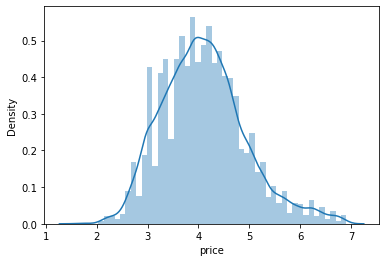

In [722]:
sns.distplot(df['price'])
plt.show()

In [14]:
k = 21 #numero de variables
corrmat = df.corr()
cols = corrmat.nlargest(k, 'price')['price'].index[1:]

from sklearn.model_selection import train_test_split
X_var = df[cols].values
y_var = df['price']

X_train, X_test, y_train, y_test = train_test_split(X_var, y_var, test_size = 0.3, random_state = 0)

from sklearn.preprocessing import MinMaxScaler

scaler_x = MinMaxScaler()
scaler_x.fit(X_train)
X_train = scaler_x.transform(X_train)


scaler_x = MinMaxScaler()
scaler_x.fit(X_test)
X_test = scaler_x.transform(X_test)



poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
modelo = linear_model.LinearRegression()
modelo.fit(X_train_poly, y_train)


y_hat = modelo.predict(poly.transform(X_test))

print(f'El r2 = {r2_score(y_test, y_hat)} y el RMSE = {mean_squared_error(y_test,y_hat, squared=False)}')



El r2 = 0.43860331561407484 y el RMSE = 0.6355740211827947


C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


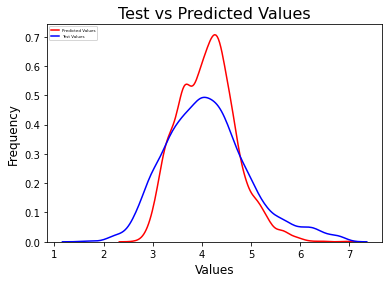

In [735]:
sns.distplot(y_hat, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Test Values')
plt.title('Test vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 4)
plt.show()

C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\alvaro\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


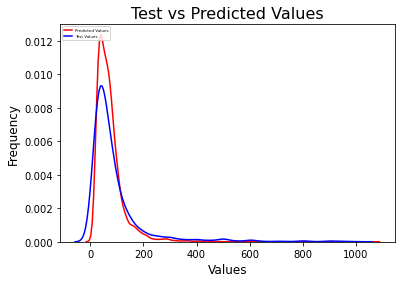

In [736]:
sns.distplot(np.exp(y_hat), hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(np.exp(y_test), hist = False, color = 'b', label = 'Test Values')
plt.title('Test vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 4)
plt.show()

In [741]:
ar1 = np.exp(y_hat)
ar2 = np.exp(y_test)
df_comprobar = pd.DataFrame()
df_comprobar['testeo'] = ar2
df_comprobar['predic'] = ar1
df_comprobar
mean_squared_error(y_hat,y_test, squared = False)

104.60821128860533

In [8]:
df.drop(axis=0,index=df['price'].sort_values().tail(6).index, inplace = True)